# Tech Team Ticket Metrics

## Retrieve Current Data

In [3]:
# SPDX-License-Identifier: Apache-2.0
# Licensed to the Ed-Fi Alliance under one or more agreements.
# The Ed-Fi Alliance licenses this file to you under the Apache License, Version 2.0.
# See the LICENSE and NOTICES files in the project root for more information.

from edfi_tech_metrics.settings import load_from_env
from edfi_tech_metrics.jira import JiraBrowser
from edfi_tech_metrics.ticket_age import write_ticket_age_files, generate_ticket_age_plots

conf = load_from_env()
#conf.log_level = "DEBUG"
browser = JiraBrowser(conf)

portfolios = {
    "ODS Platform": ["ODS", "PERF"],
    "Team B": ["METAED", "DMS", "ADMINAPI"],
    "Ed-Fi Tools": ["AA", "AC", "APIPUB", "DI", "EPPETA"],
    "Data Standard": [ "DATASTD", "MODL", "TPDMDEV"],
    "Support": ["EDFI"]
}

projects = [i for _, v in portfolios.items() for i in v]

Connecting to https://tracker.ed-fi.org


In [ ]:
df = browser.get_unresolved_tickets(projects)

write_ticket_age_files(df)

In [ ]:

##### Cut this after testing
import pandas as pd
from datetime import datetime
from pathlib import Path

today = datetime.today().strftime('%Y-%m-%d')

def write_stats_file(df: pd.Dataframe, directory: str) -> None:
    stats_df = df[["project", "age"]].groupby(by="project").describe()
    stats_df.reset_index(inplace=True)

    stats_df.columns = stats_df.columns.to_flat_index()
    stats_df.columns = ["project", "count", "mean", "std", "min", "25%", "50%", "75%", "max"]

    stats_df["date"] = today

    Path(f"./data/{directory}").mkdir(parents=True, exist_ok=True)

    file_name = f"./data/{directory}/{today}.csv"
    conf.info(f"Writing age data out to file: {file_name}")
    stats_df.to_csv(file_name)
    
    #stats_df

write_stats_file(df, "ticket-age")

filtered = df[(df["issuetype"] != "Test") & (df["fixVersions"].notnull())]
write_stats_file(filtered, "ticket-age-filtered")

## Ticket Age

The plots below are [density estimate curves](https://en.wikipedia.org/wiki/Kernel_density_estimation), showing
the approximate (smoothed) _proportion_ of tickets at a given age. Since these are proportions, not counts, the
total adds up to 1. A density estimate is a continuous version of the blocky histogram.

The black line represents the _mean_ or average ticket age. The darker region around that represents a single
standard deviation away from the mean in both directions. The overall goal is to improve the mean; using the
standard deviation, one might focus on trying to clean up tickets _outside_ of one standard deviation - that
is, in the rightmost tail. However, most of the tickets are concentrated within the highlighted region, and
merely modify at the right tail may not nudge the mean by much.

### All Tickets

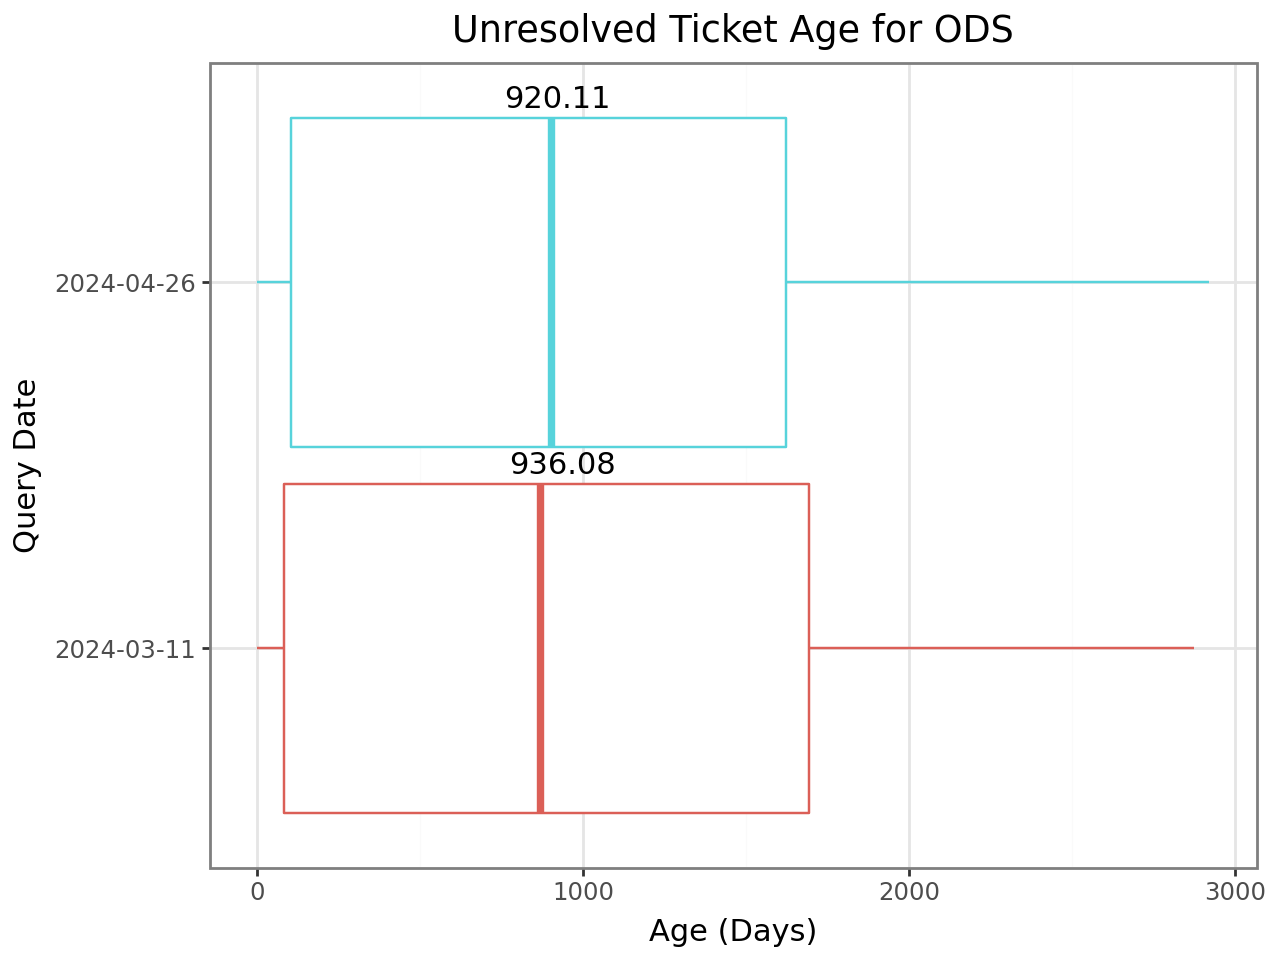

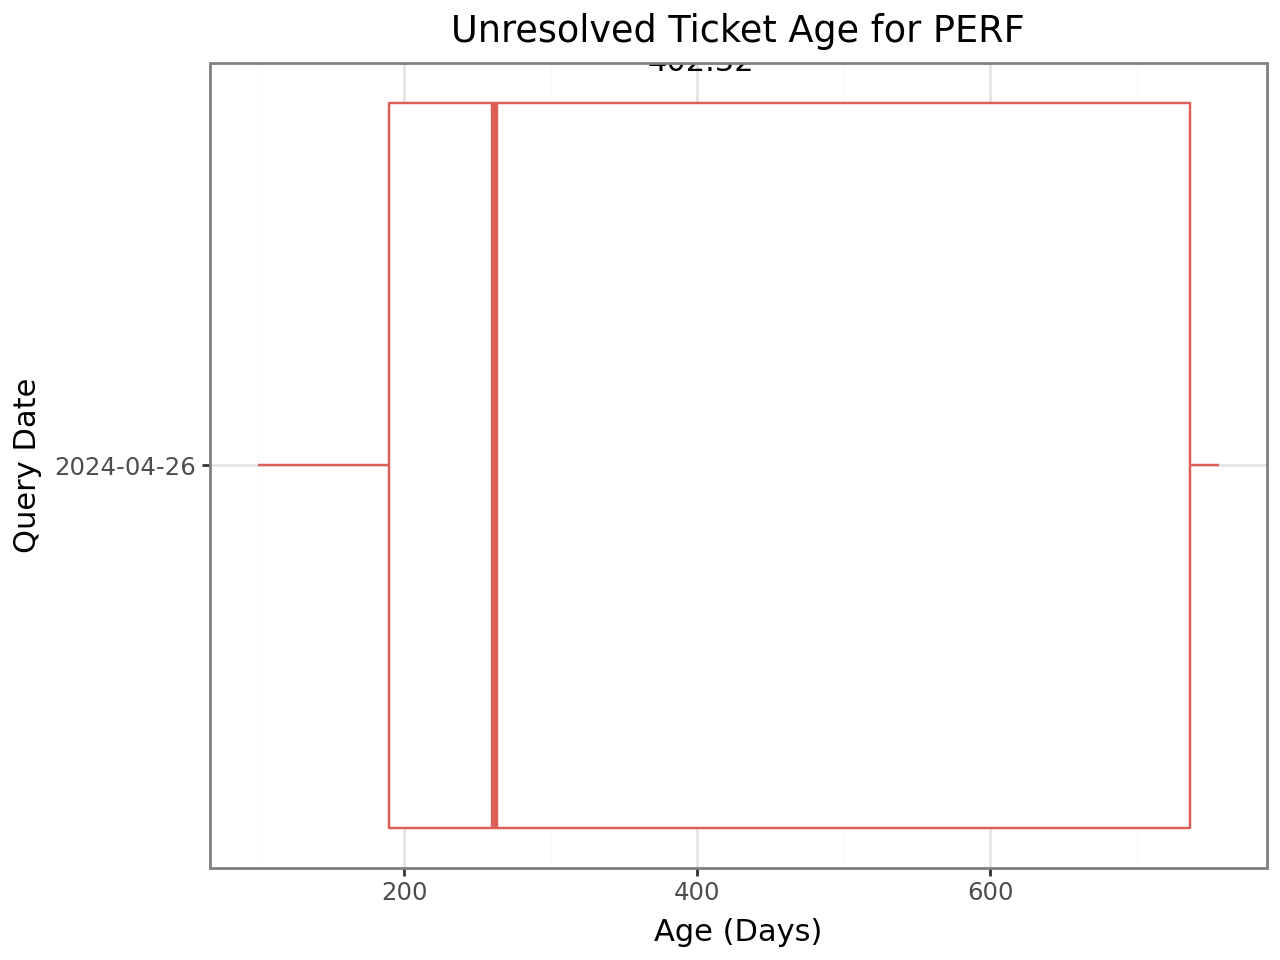

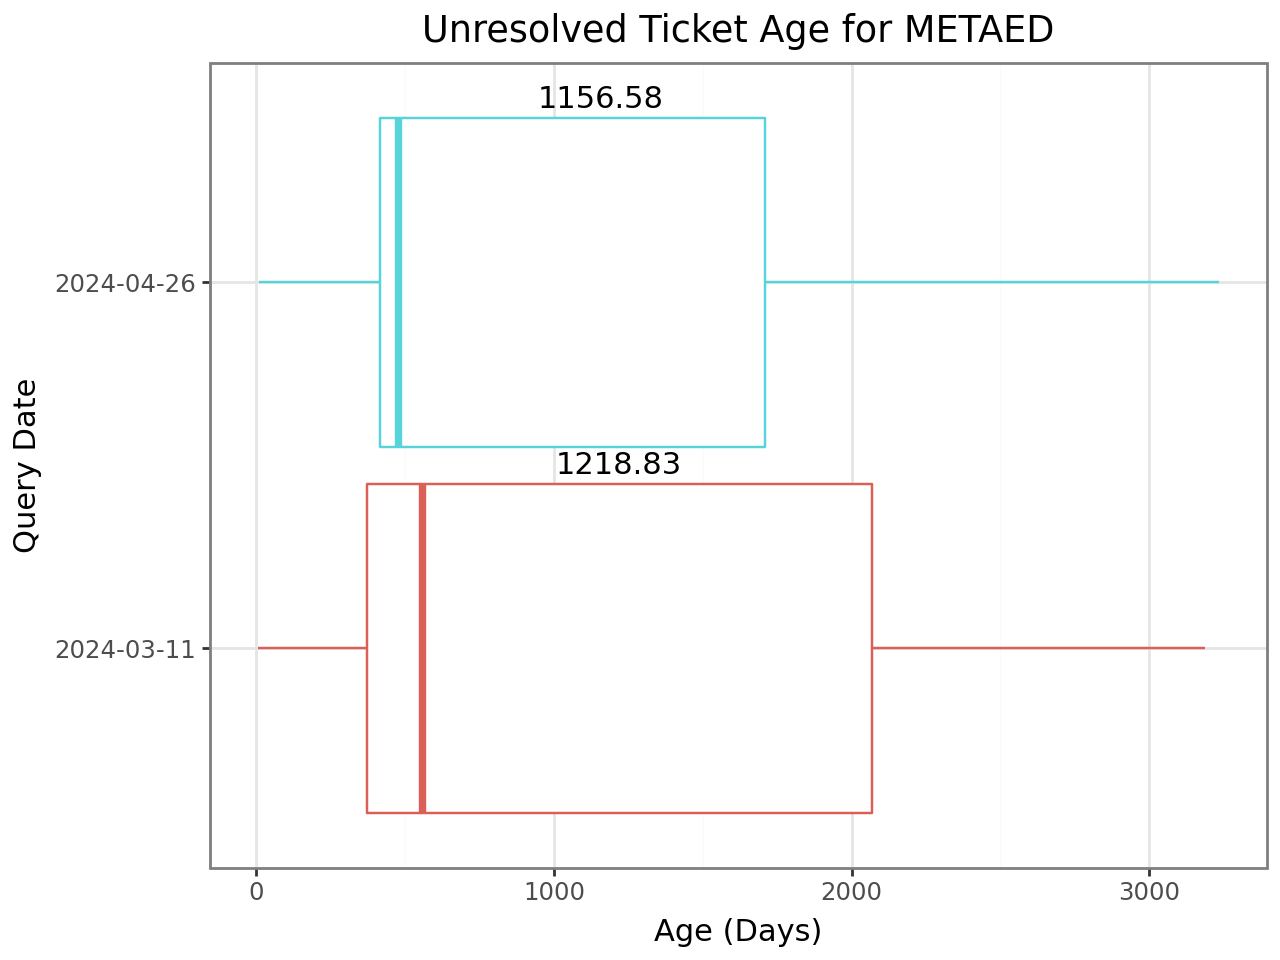

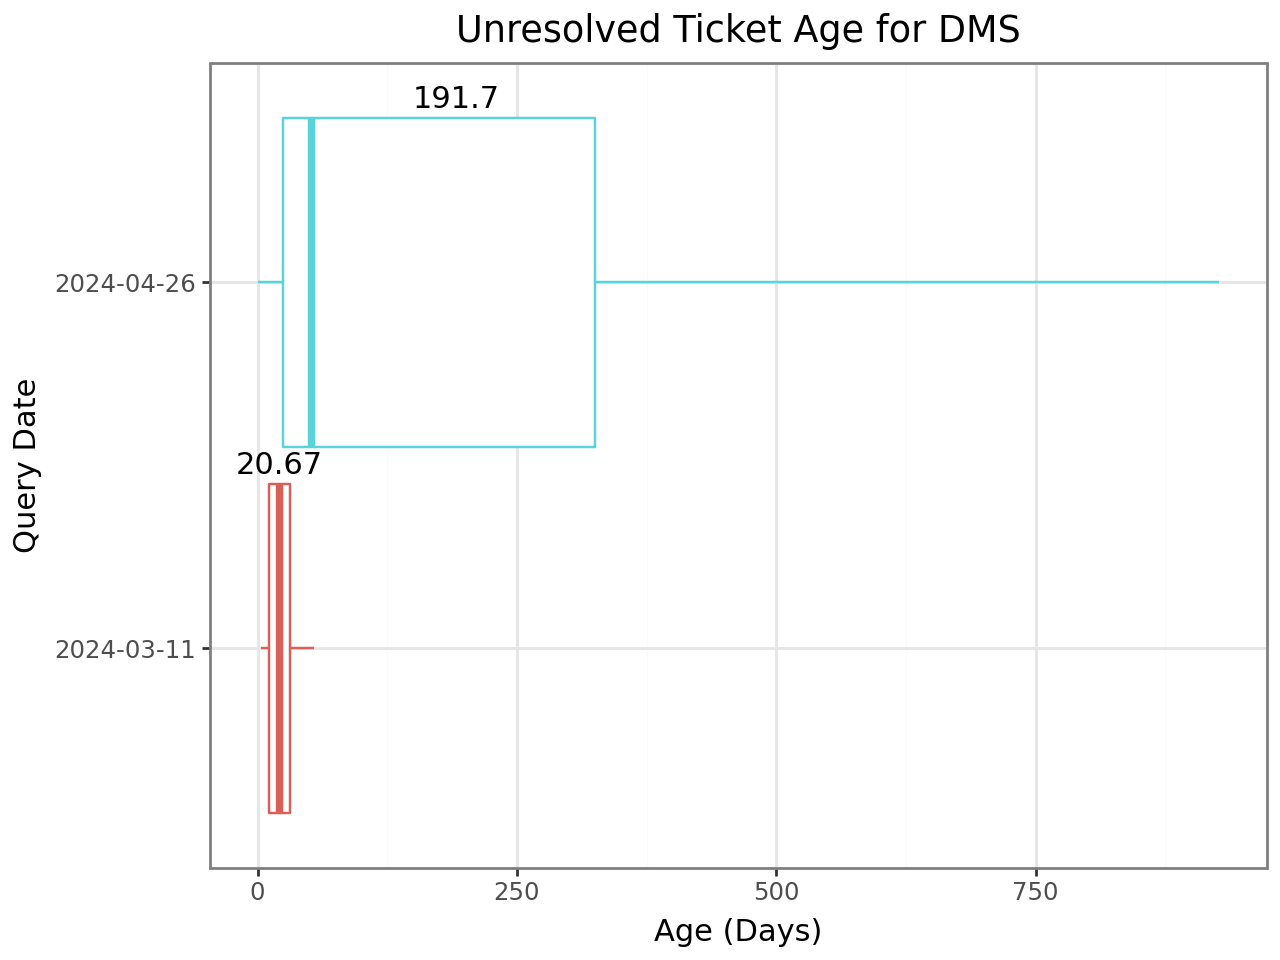

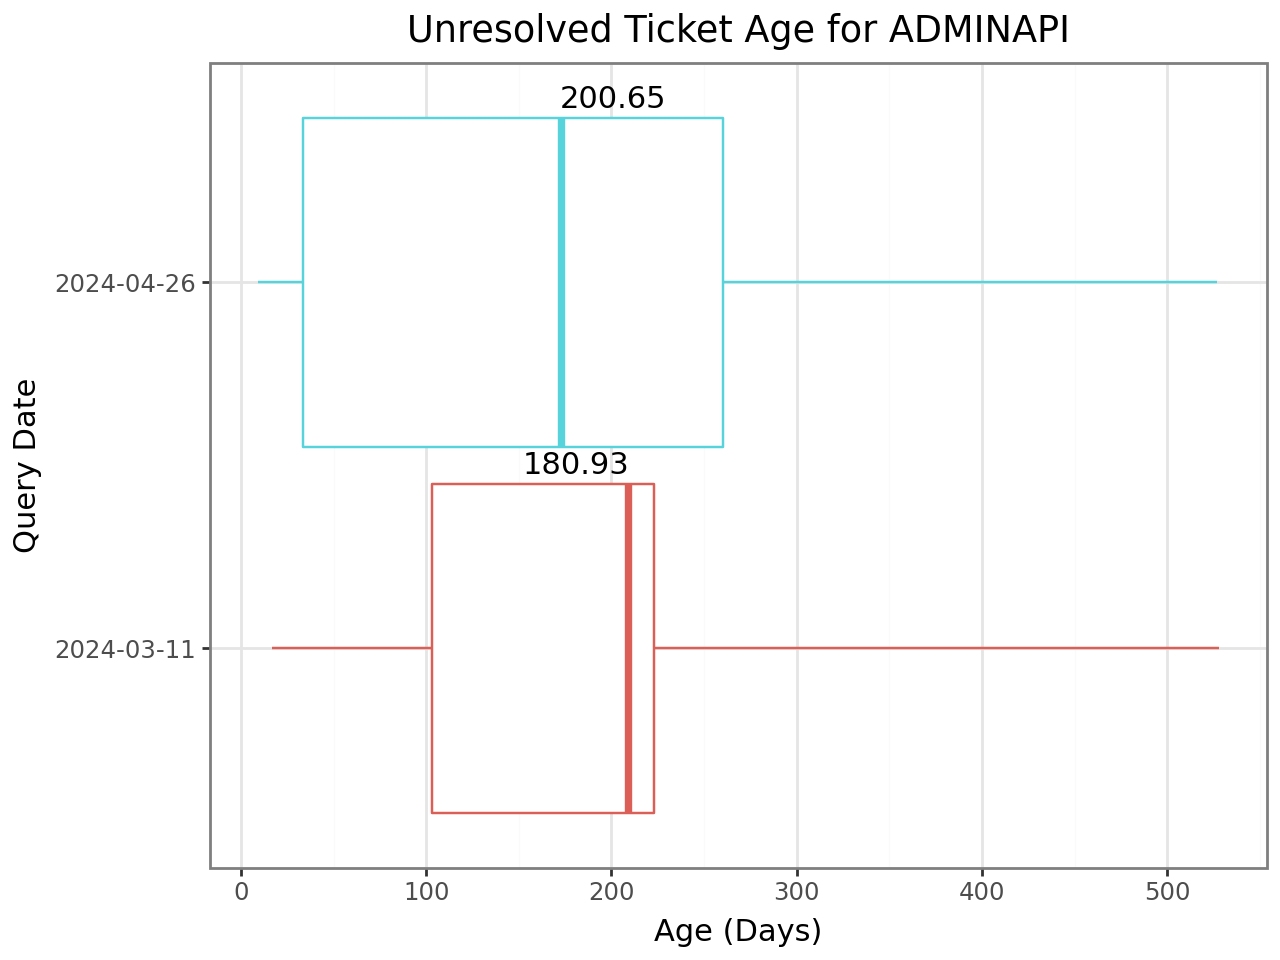

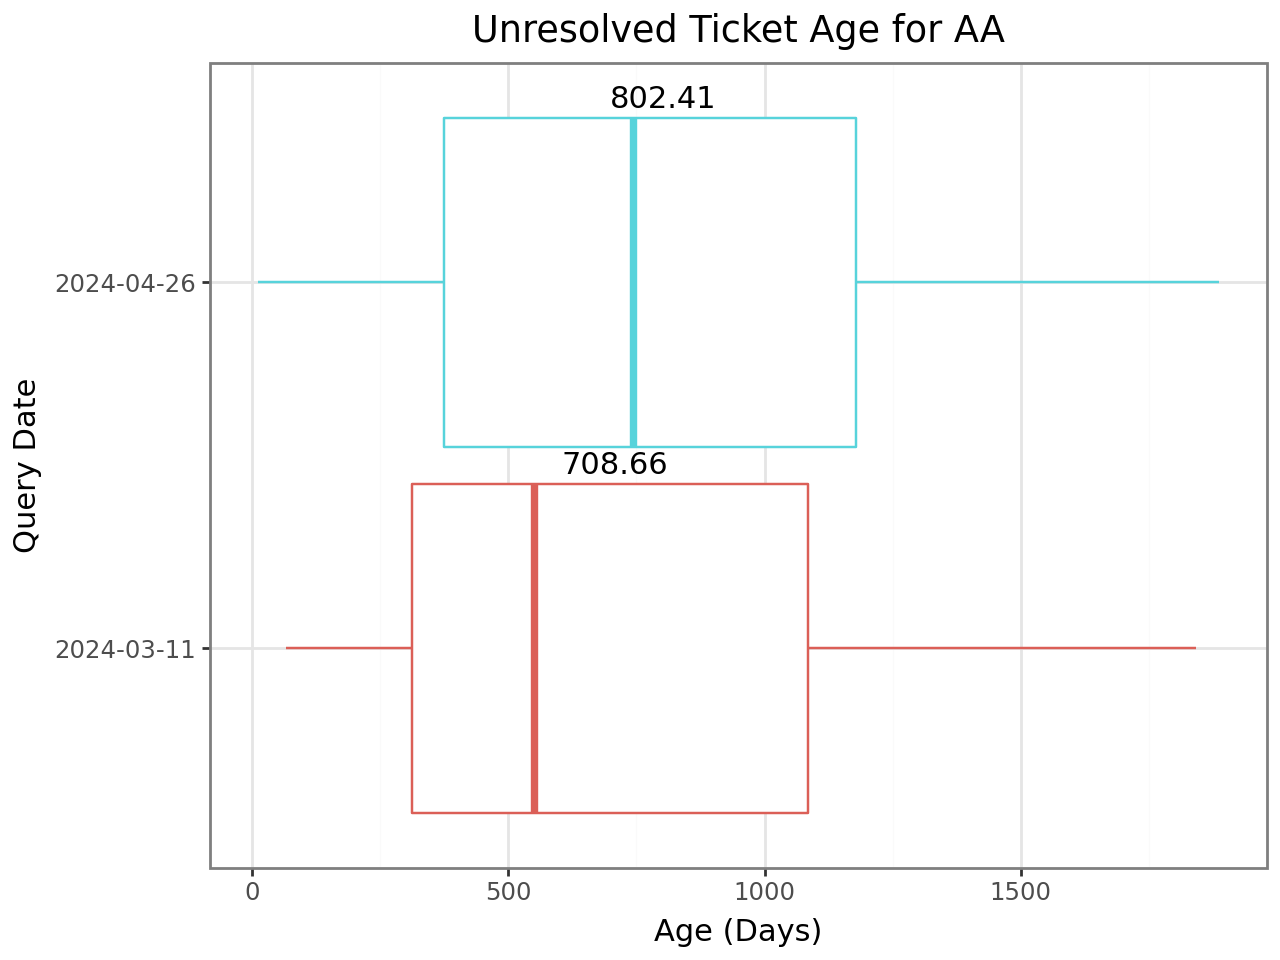

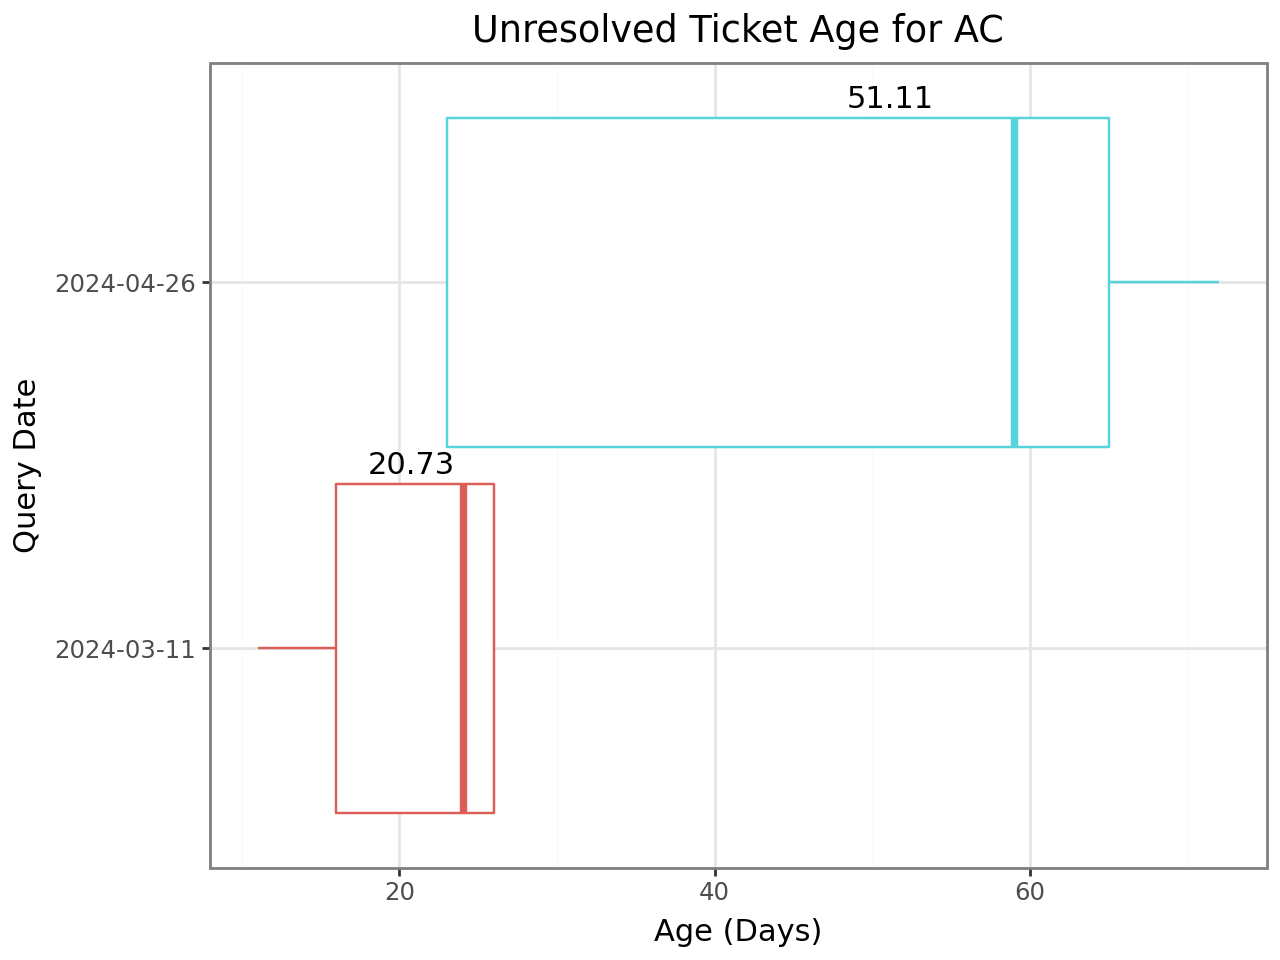

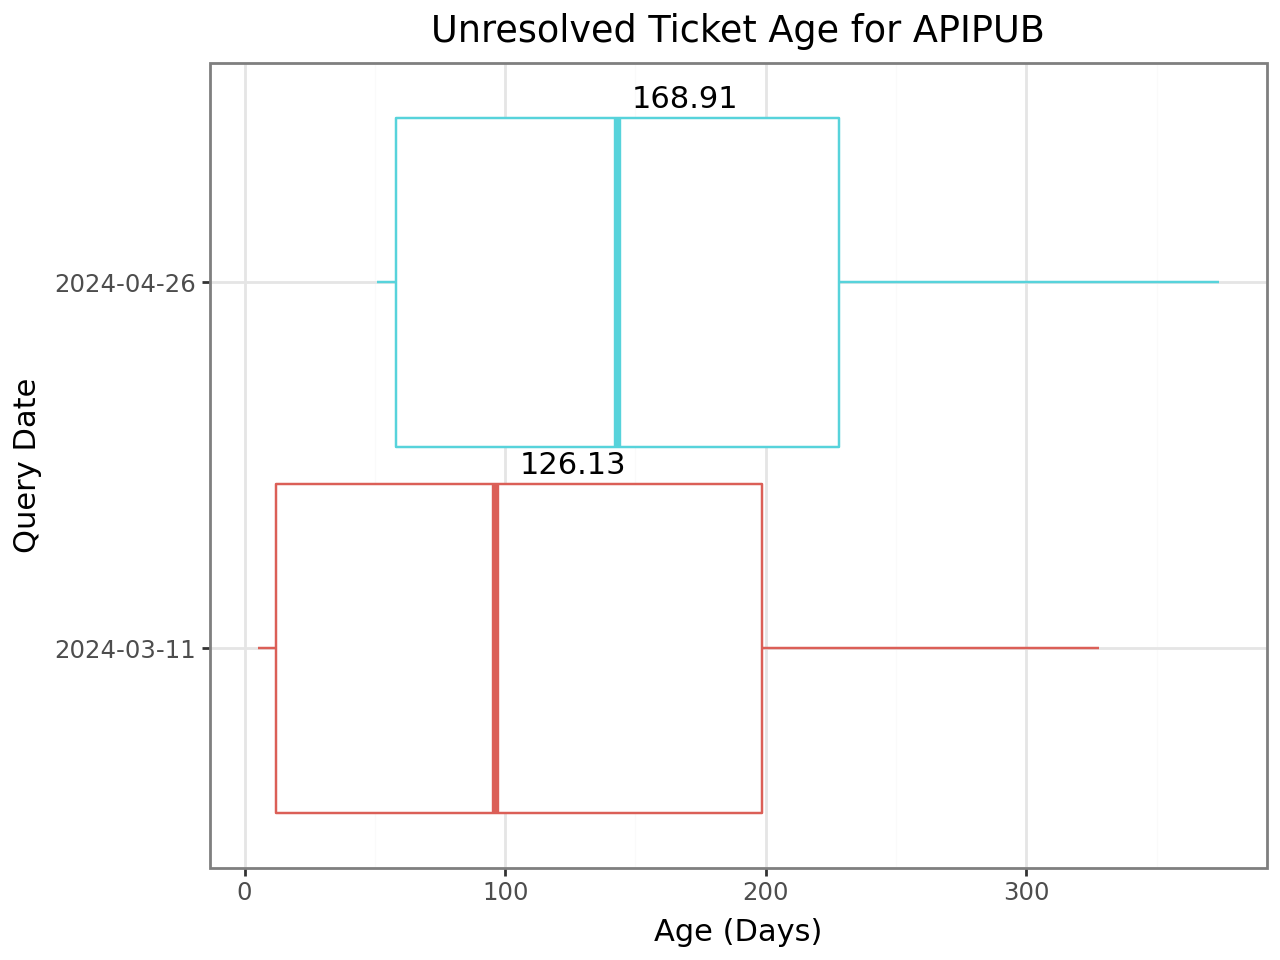

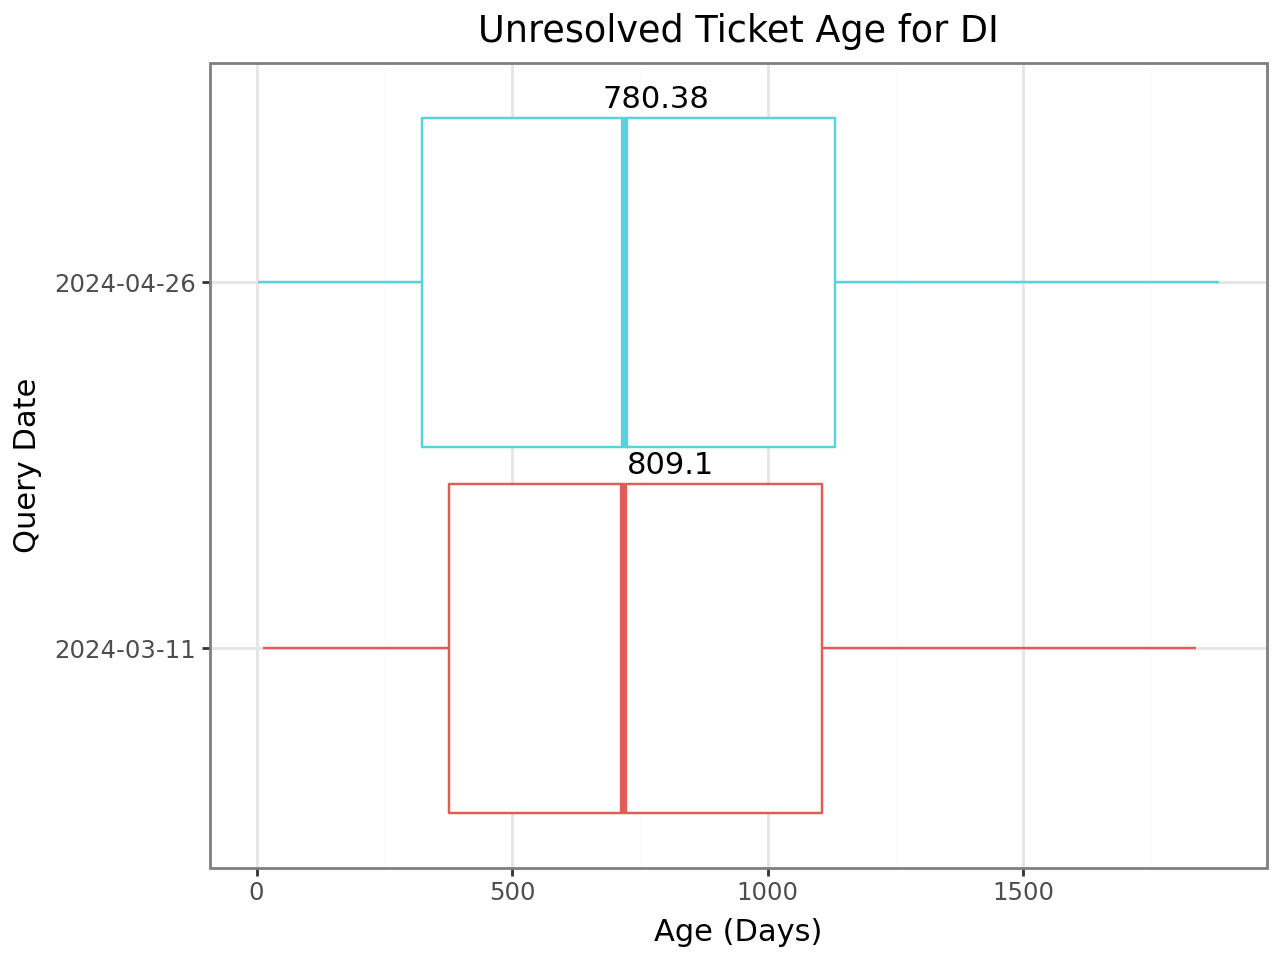

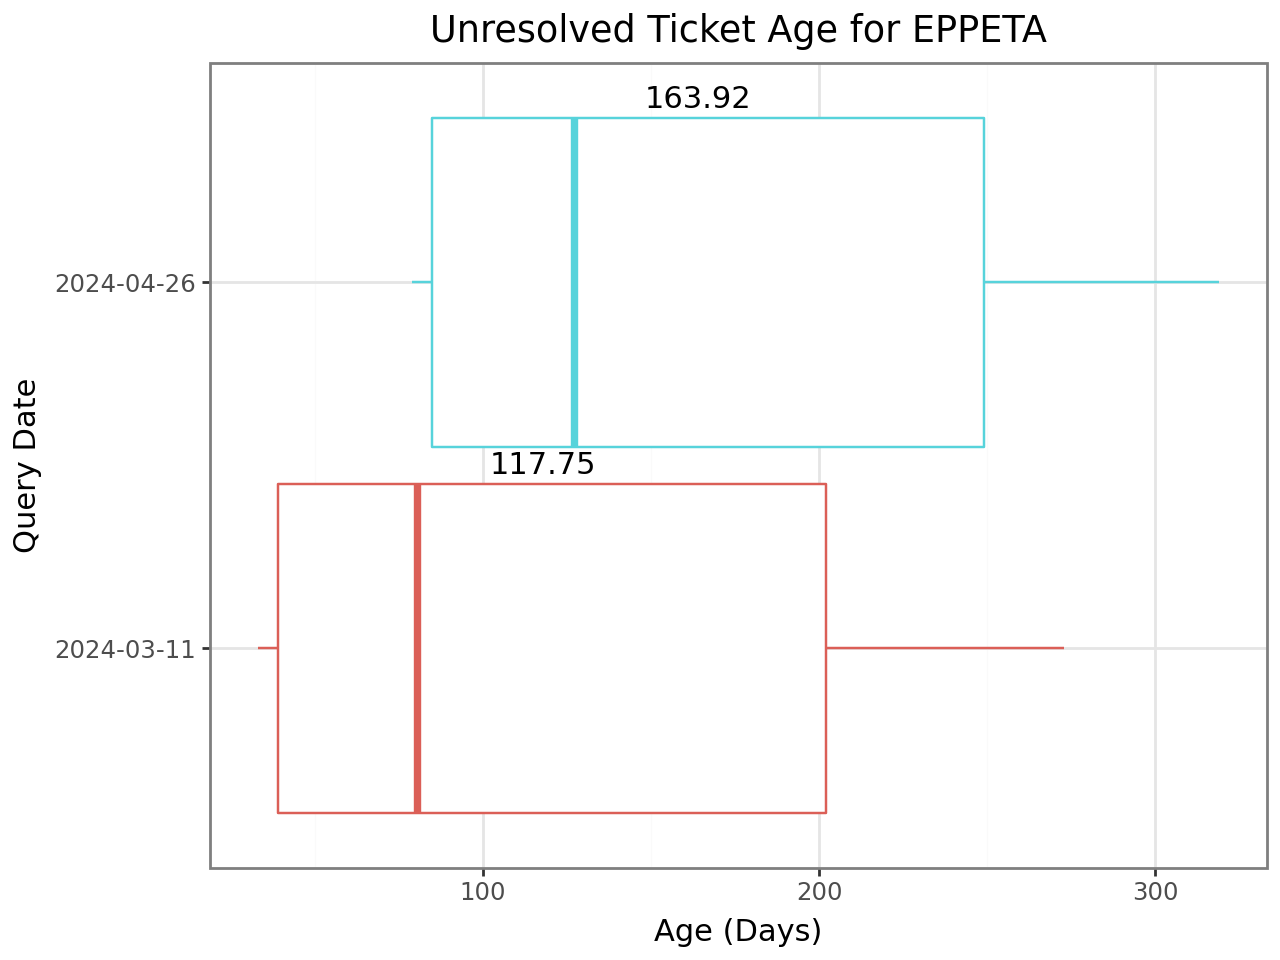

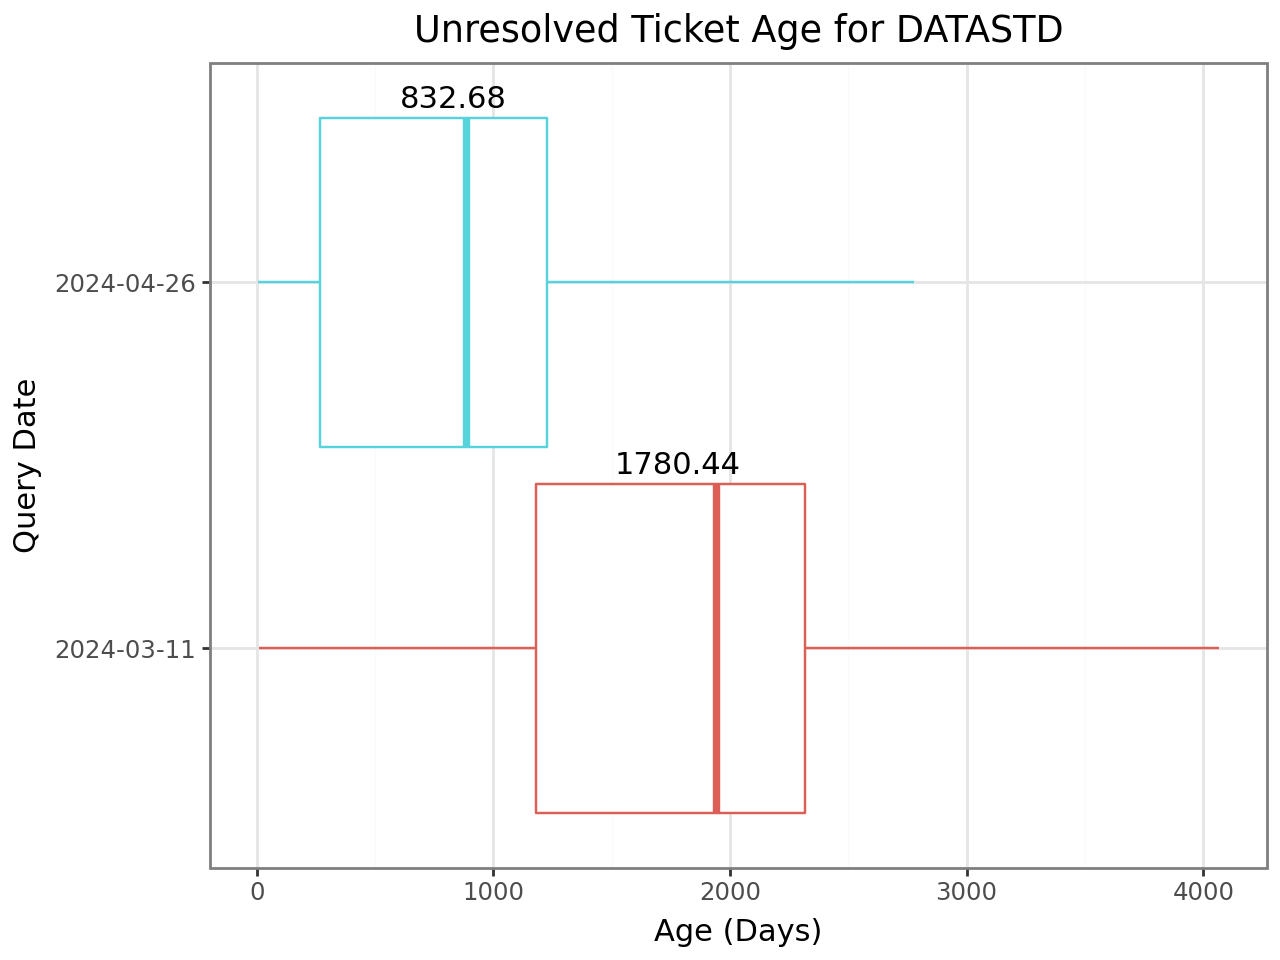

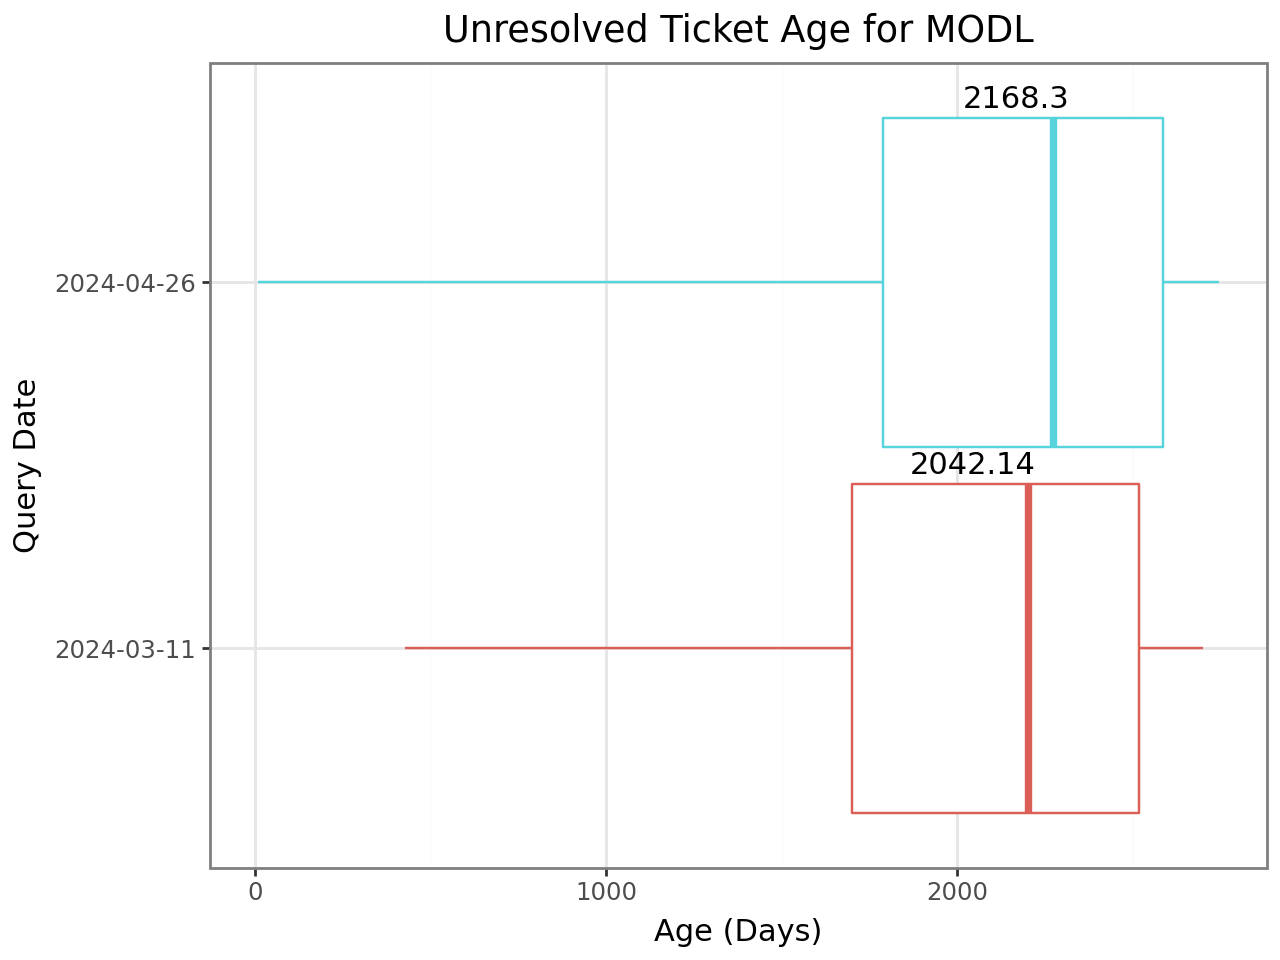

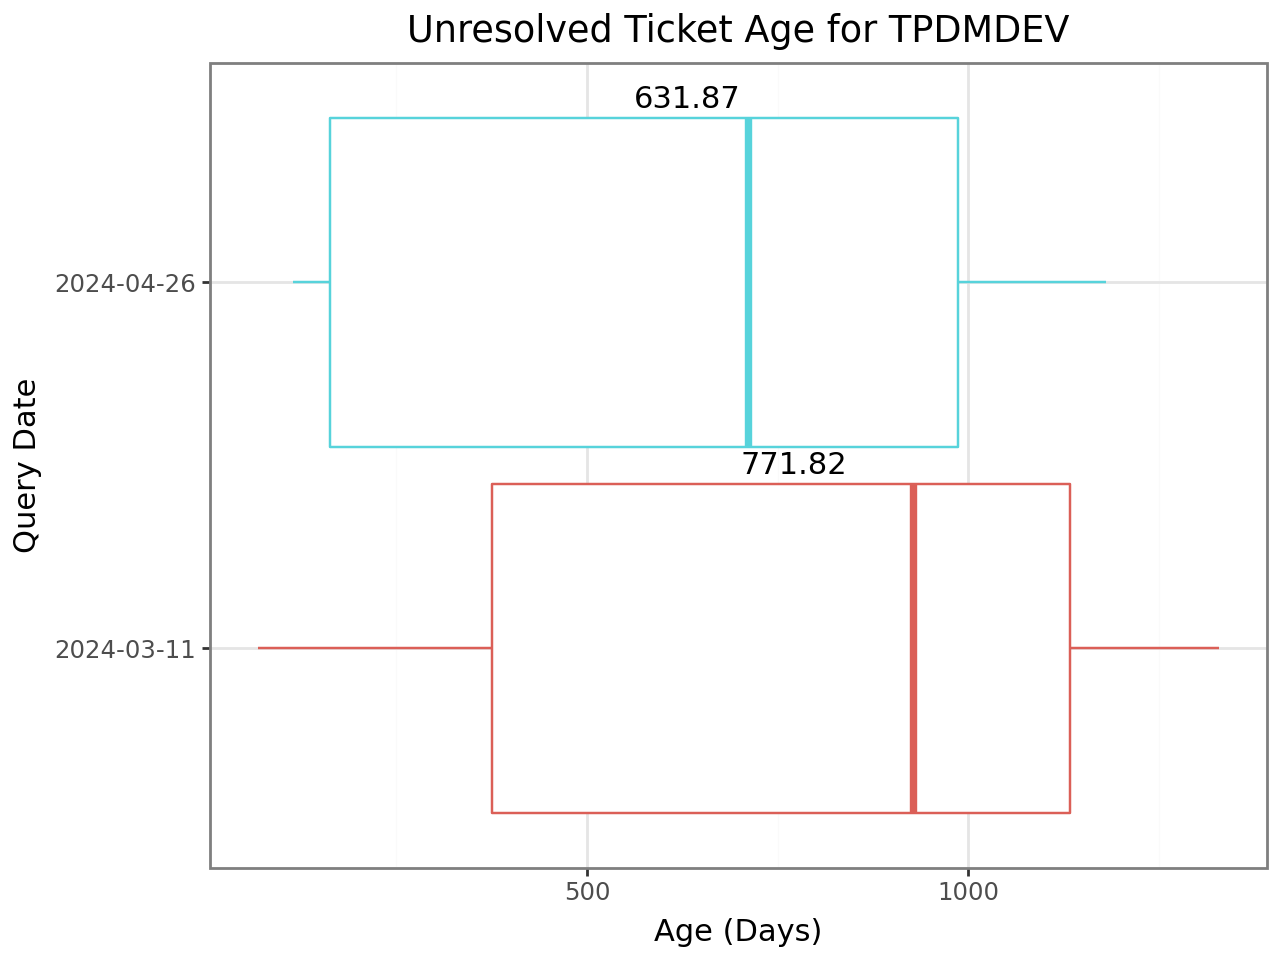

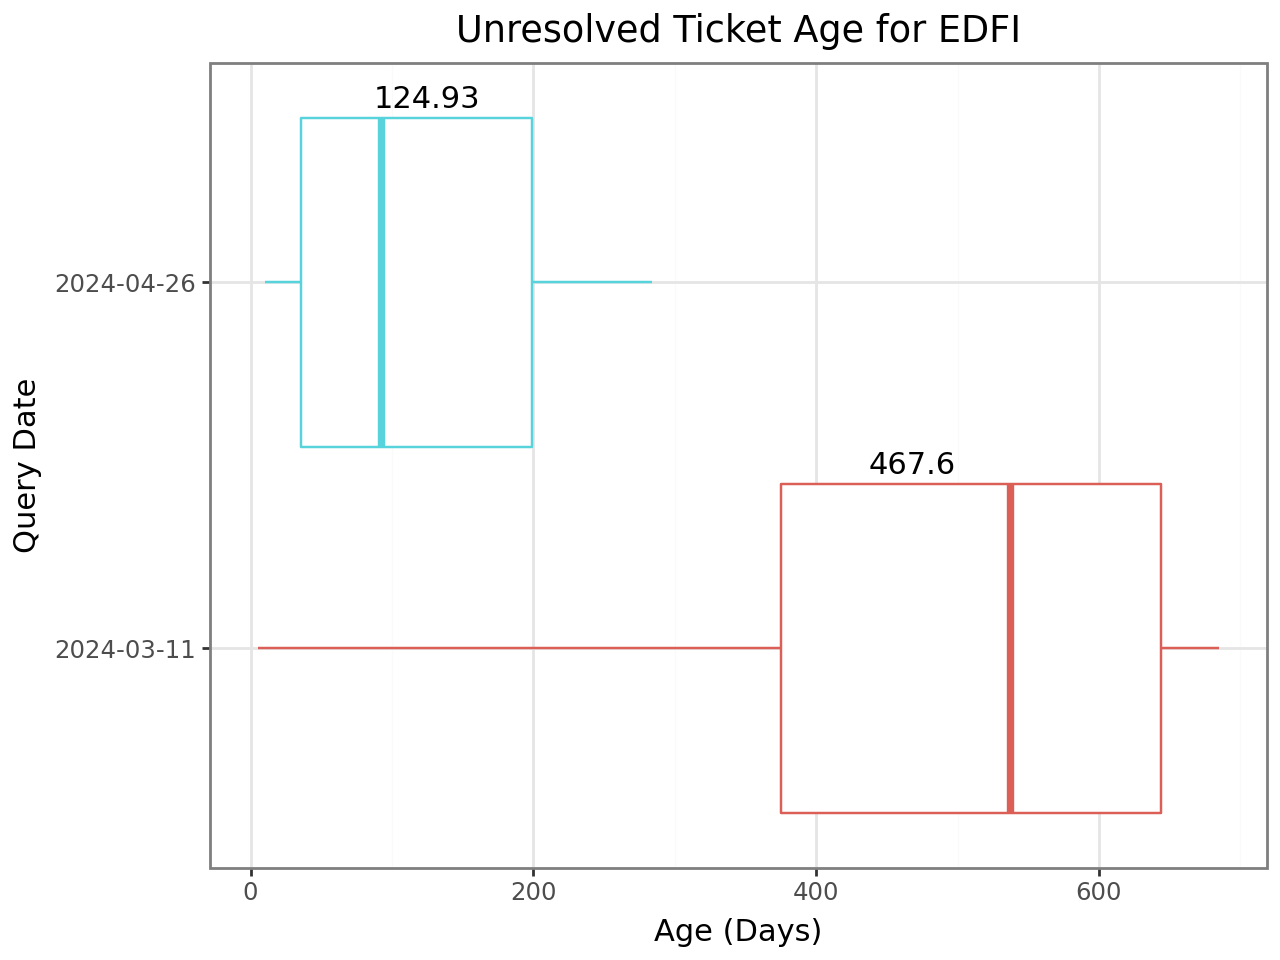

In [4]:
generate_ticket_age_plots("./data/ticket-age", projects)

### Filtered Tickets

These plots exclude "Test" type tickets and those that have an assigned Fix Version.

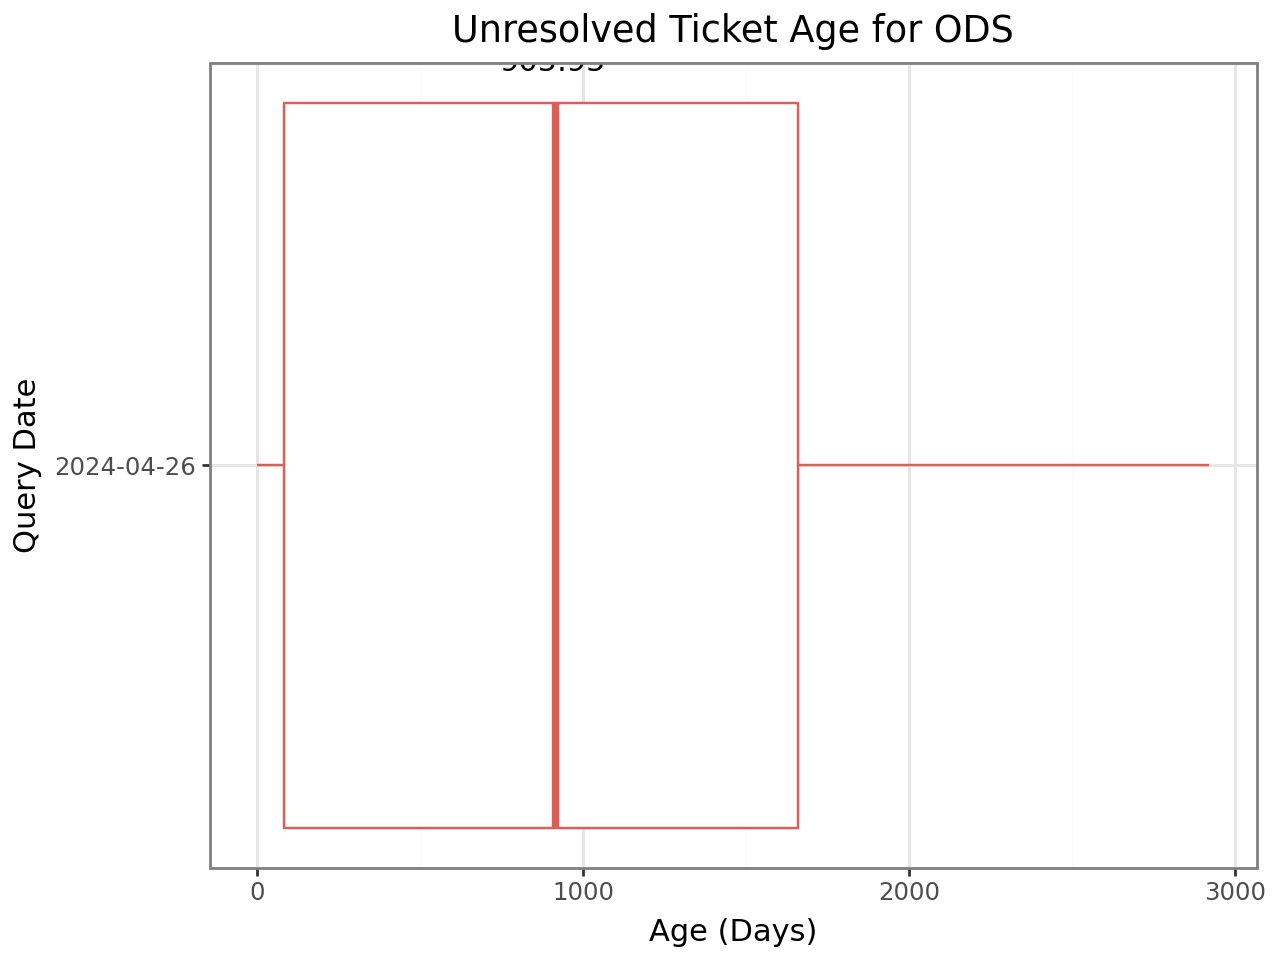

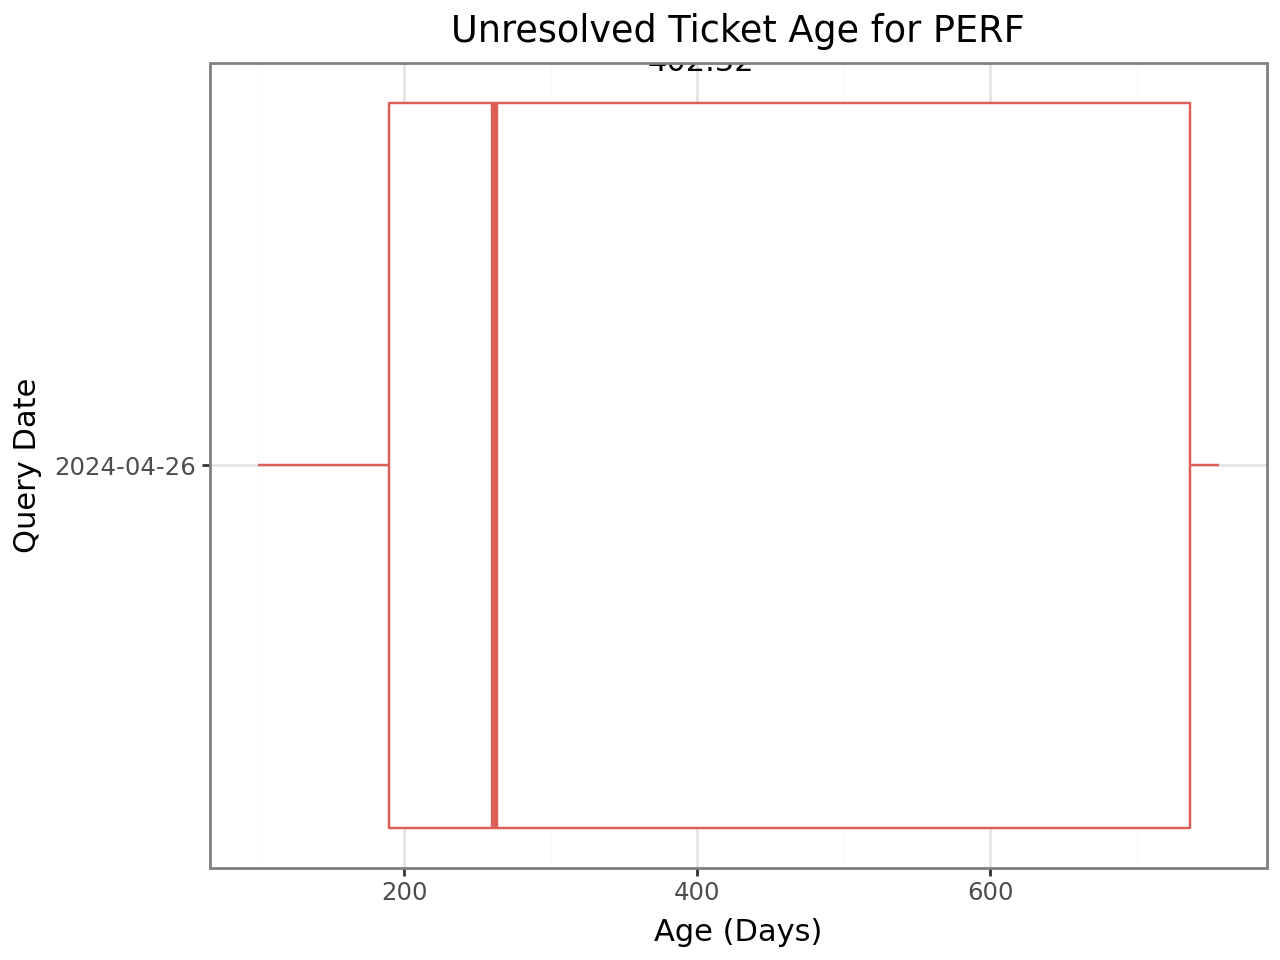

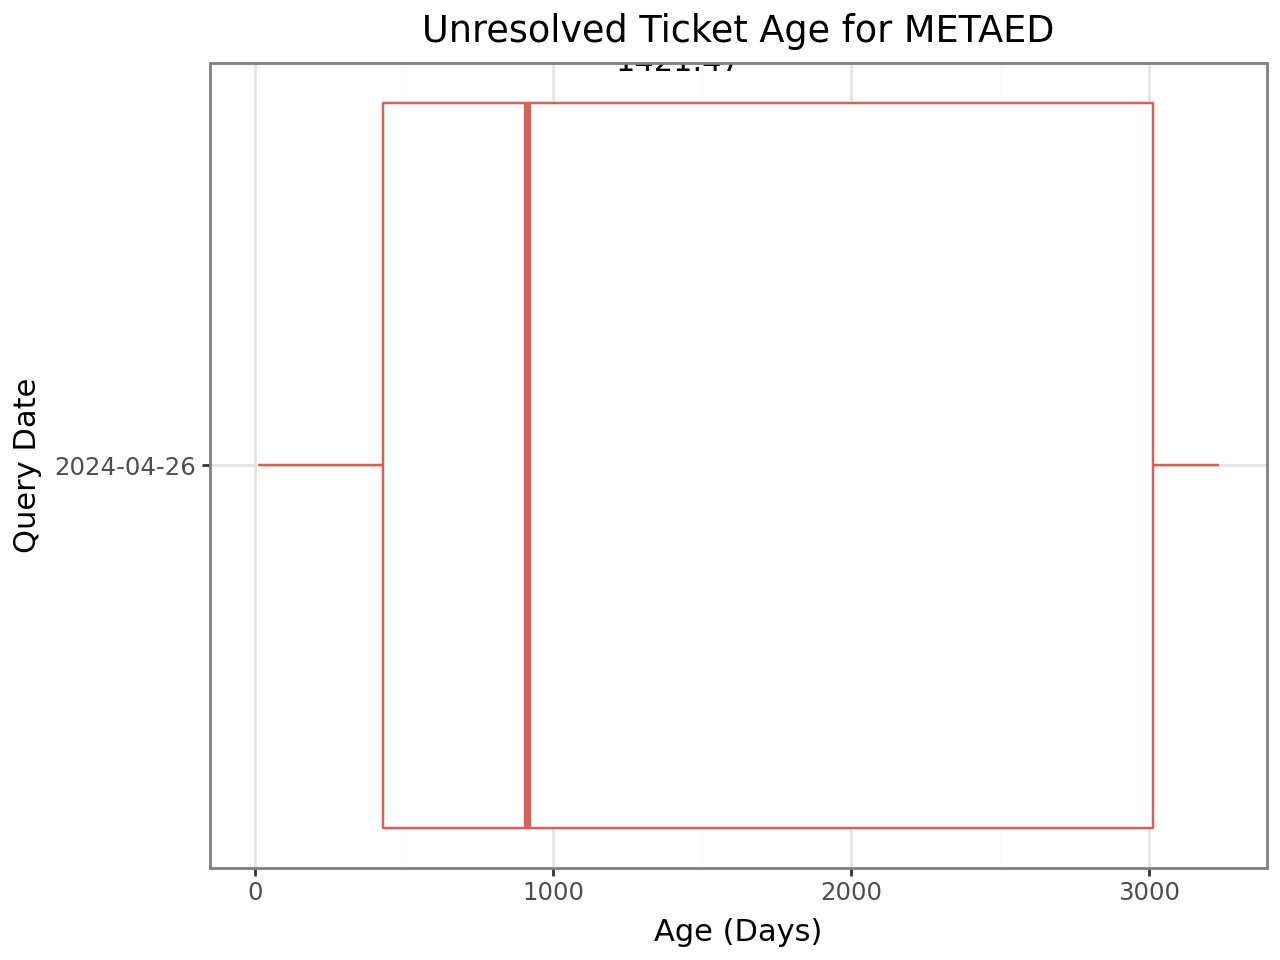

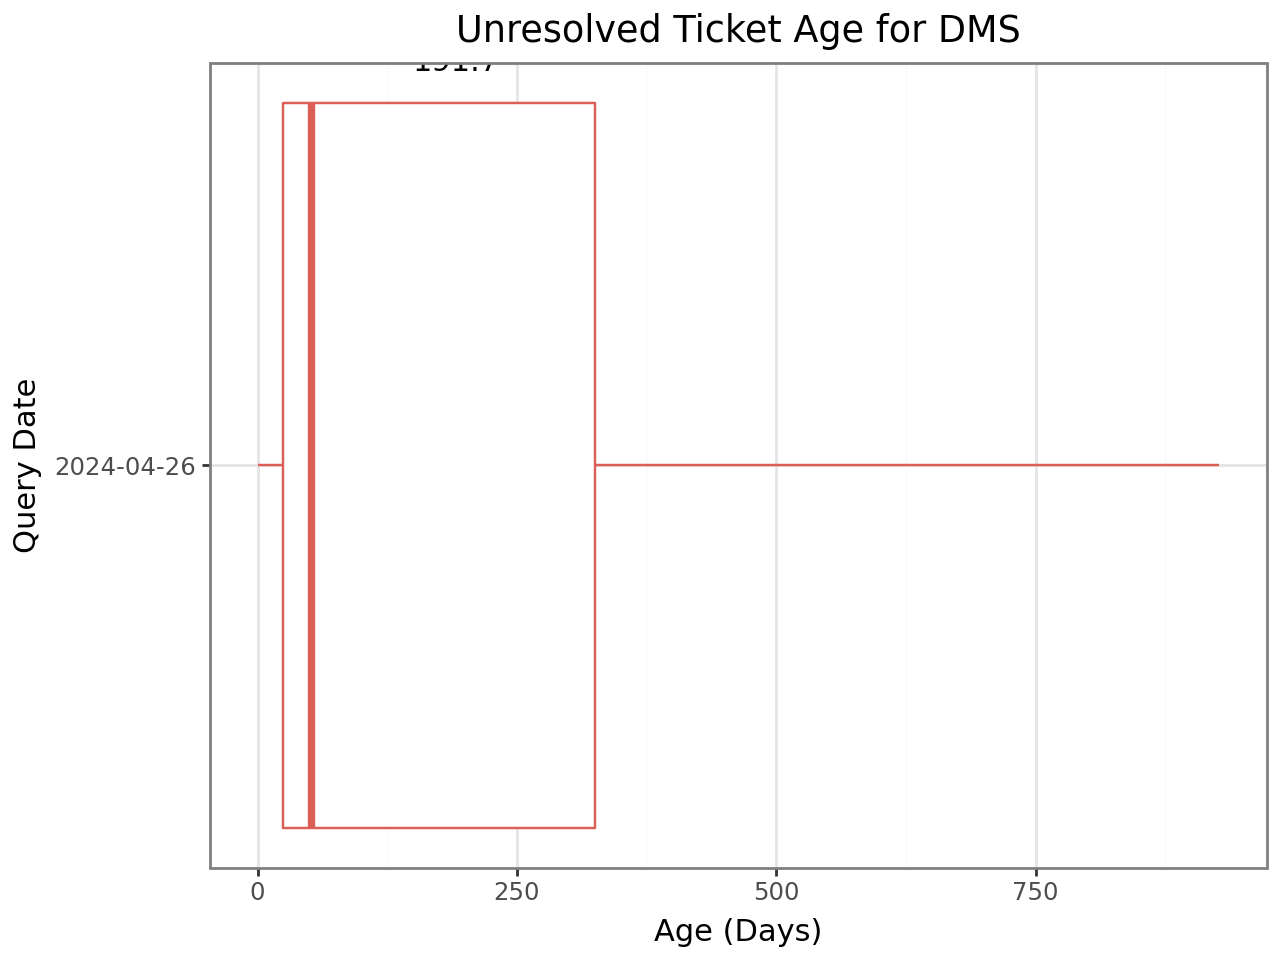

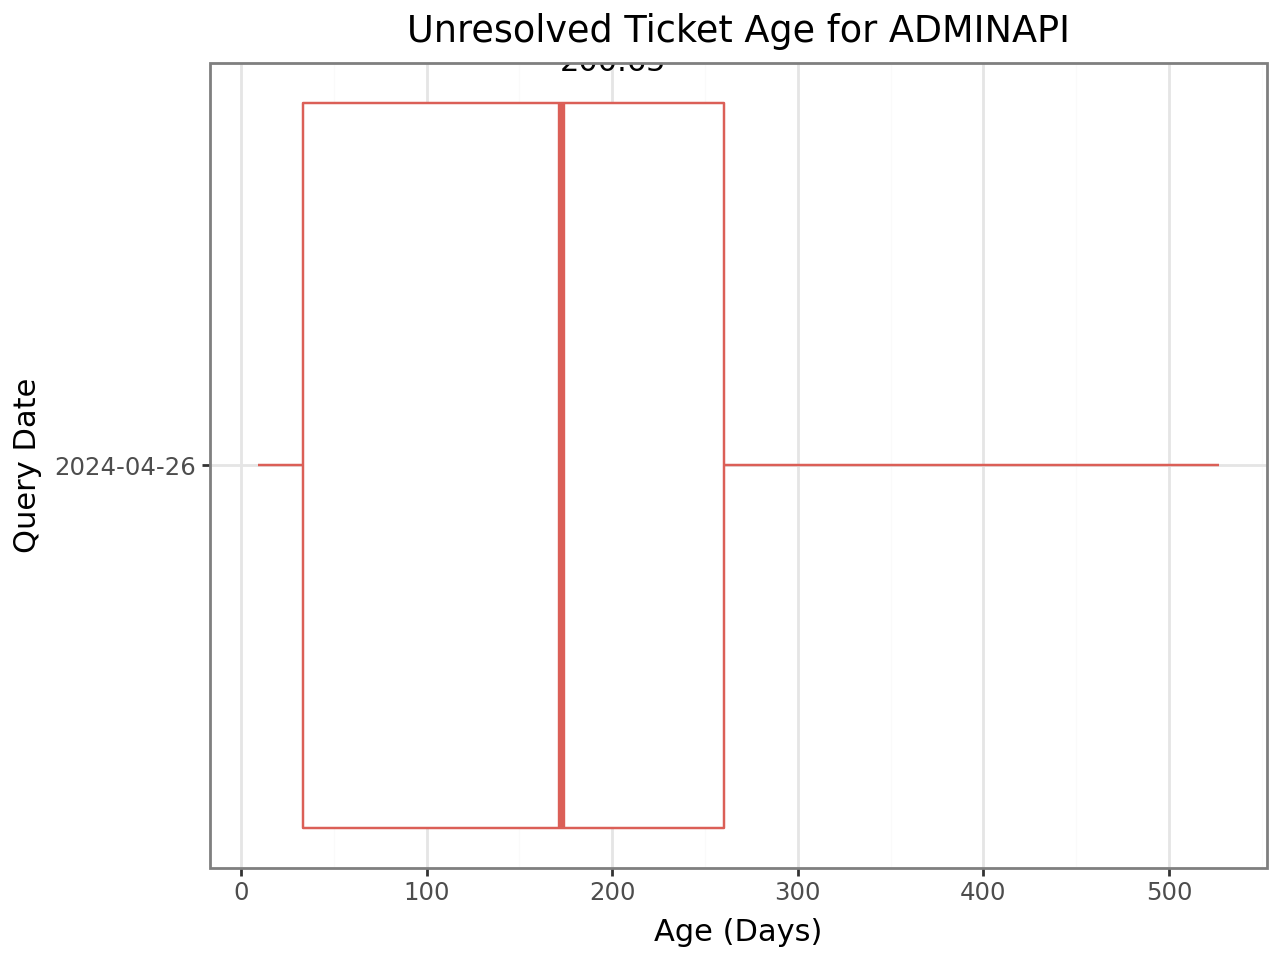

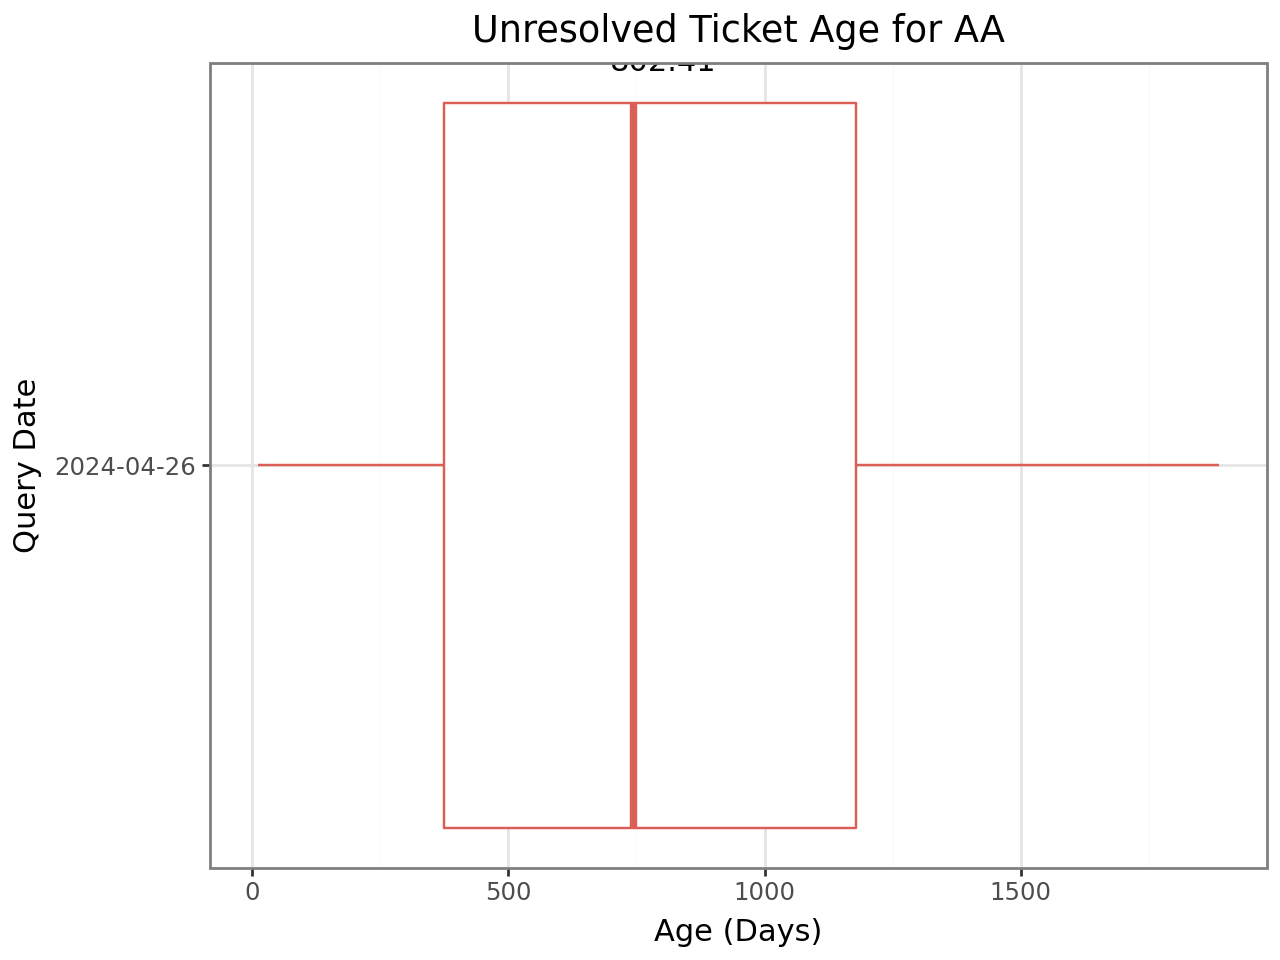

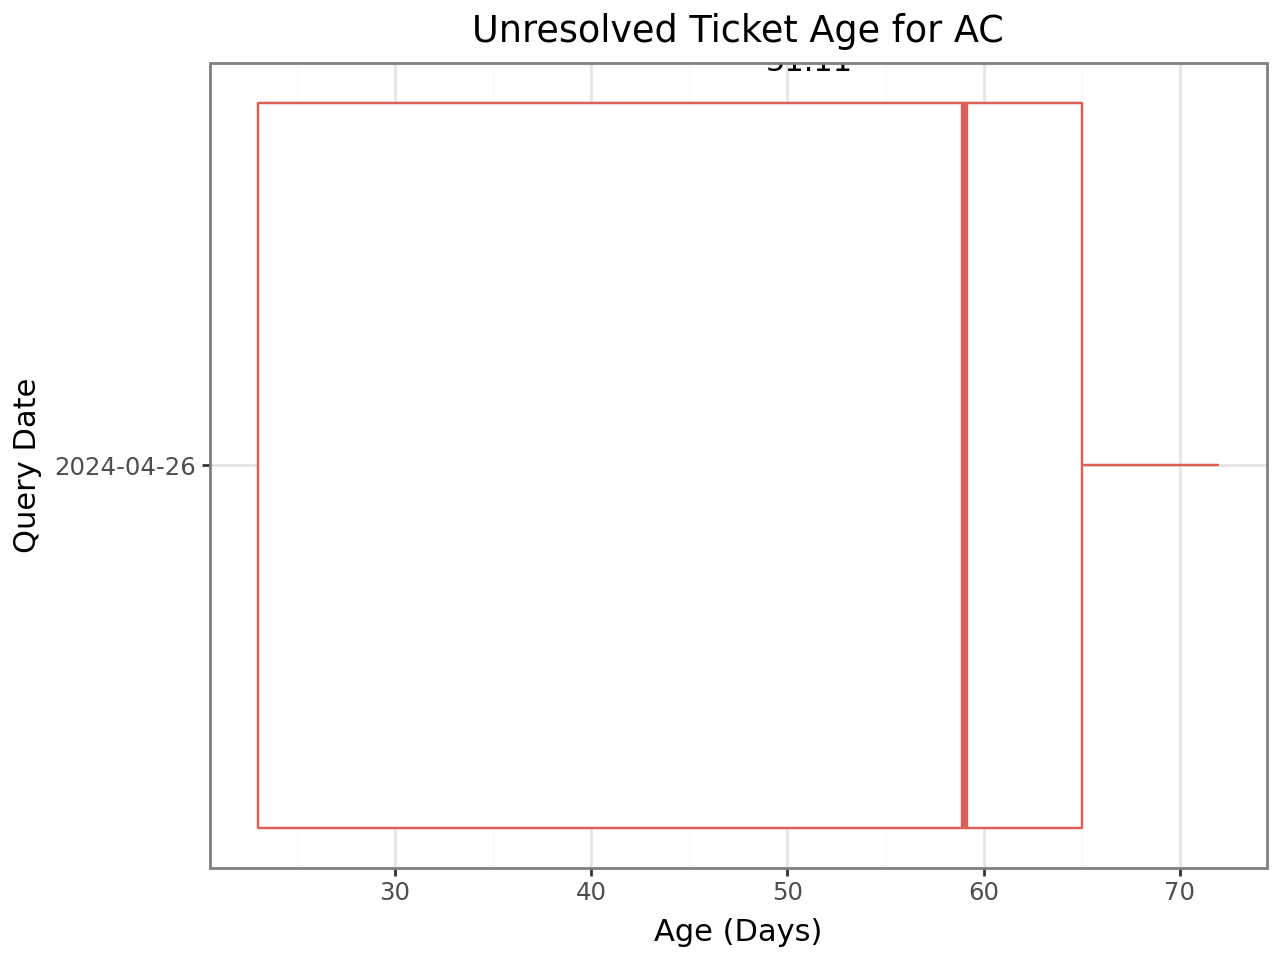

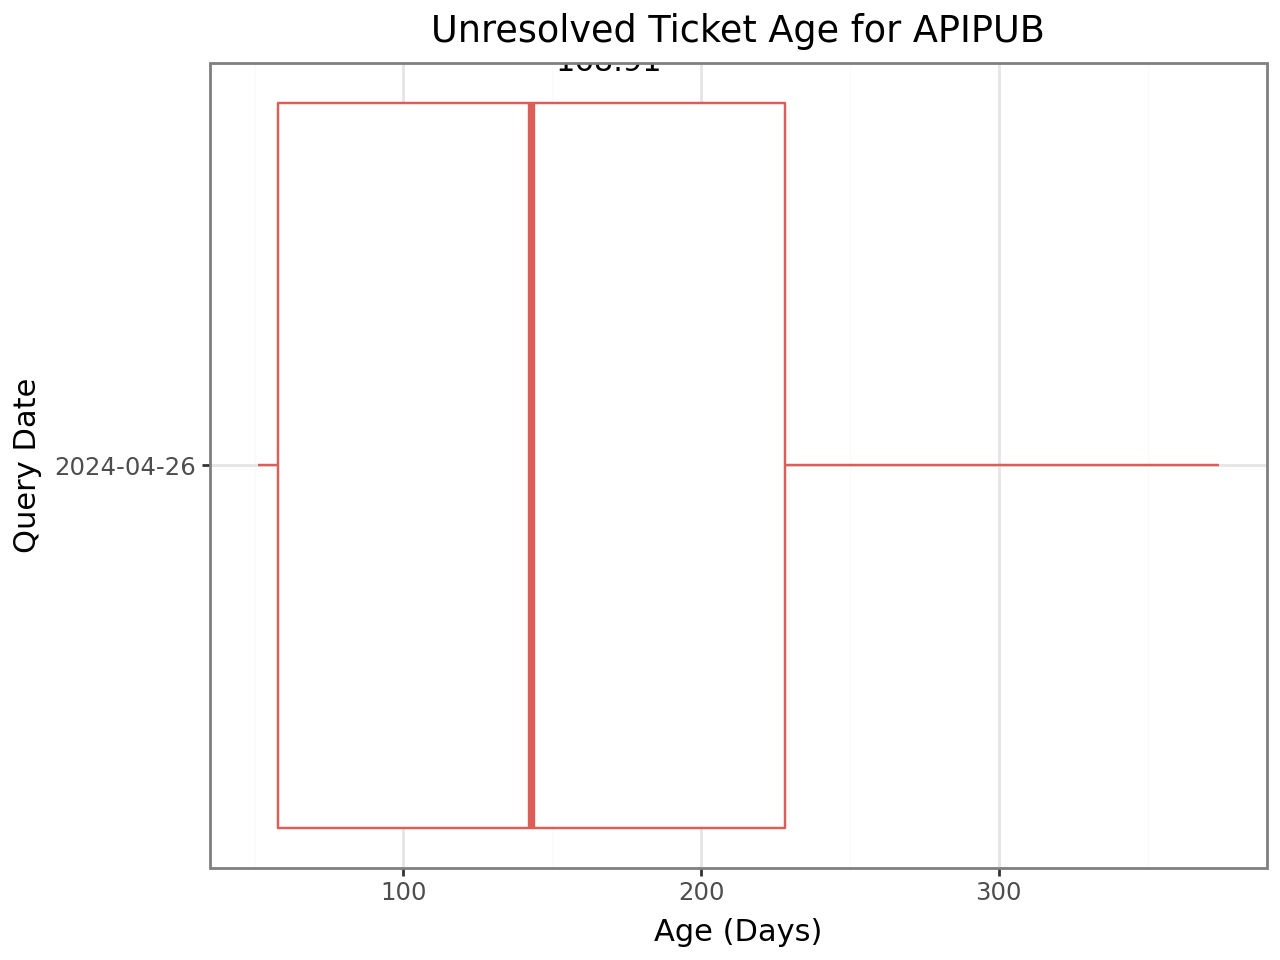

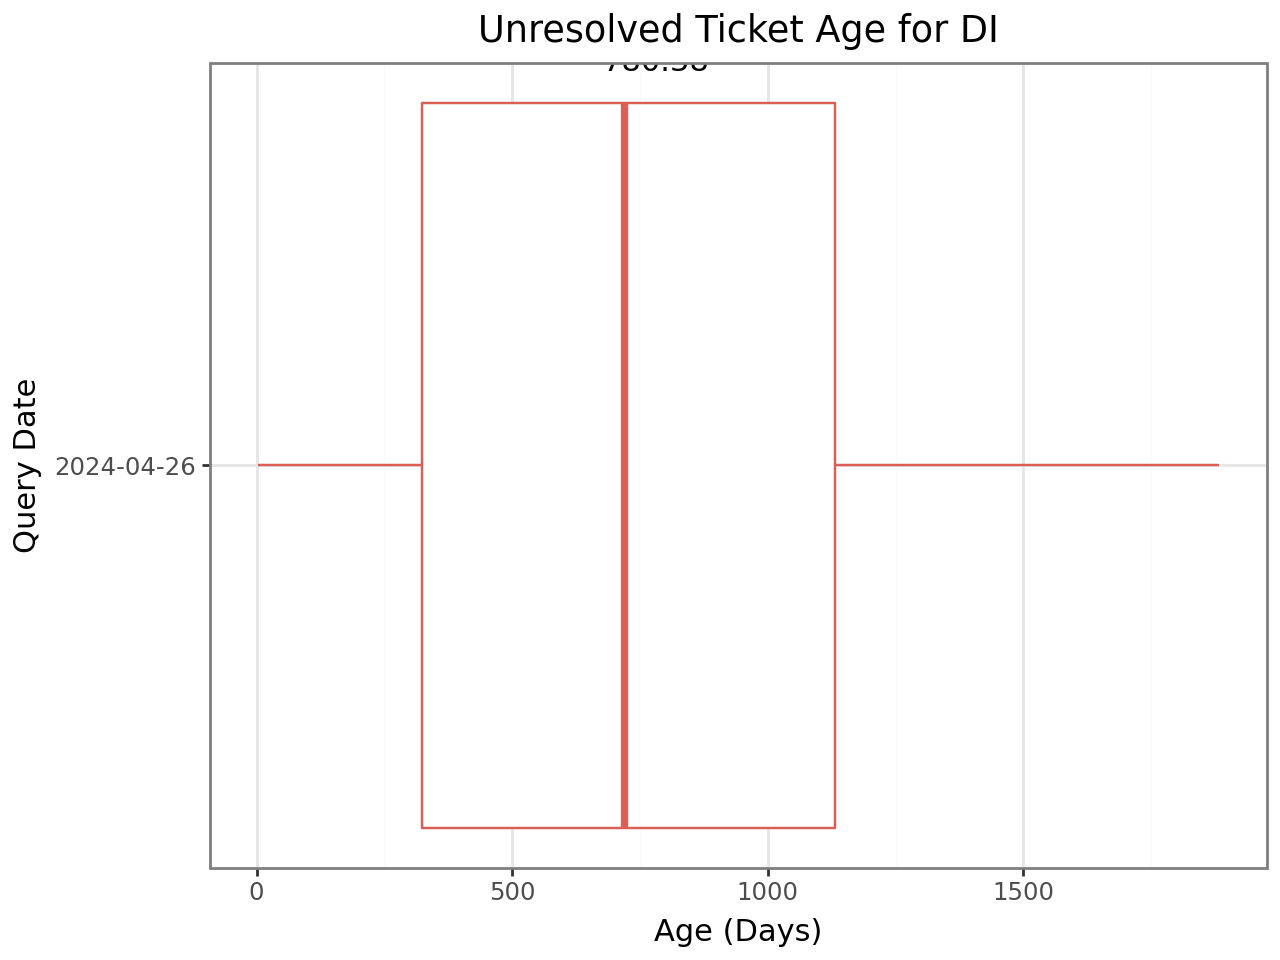

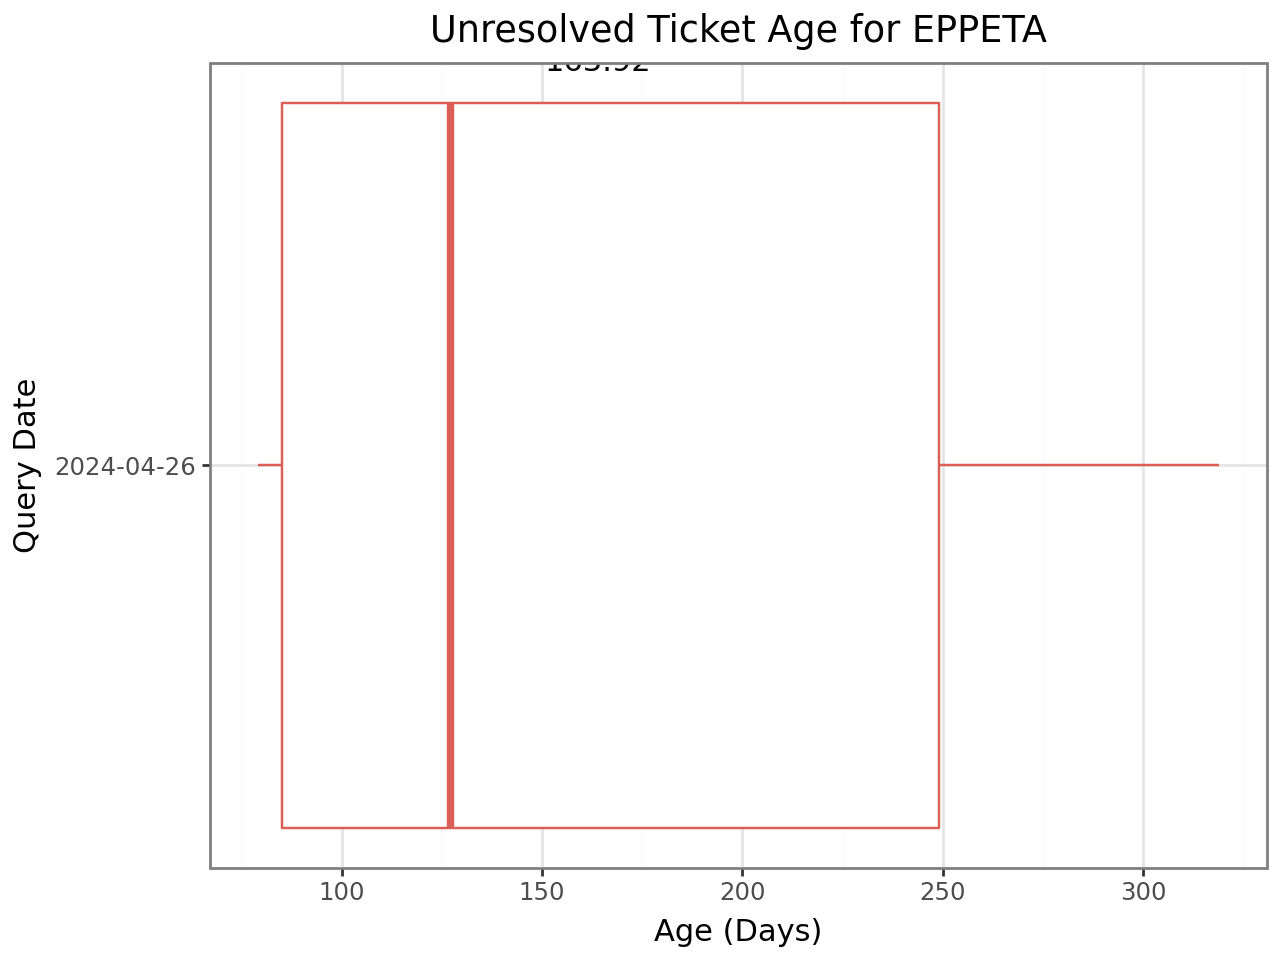

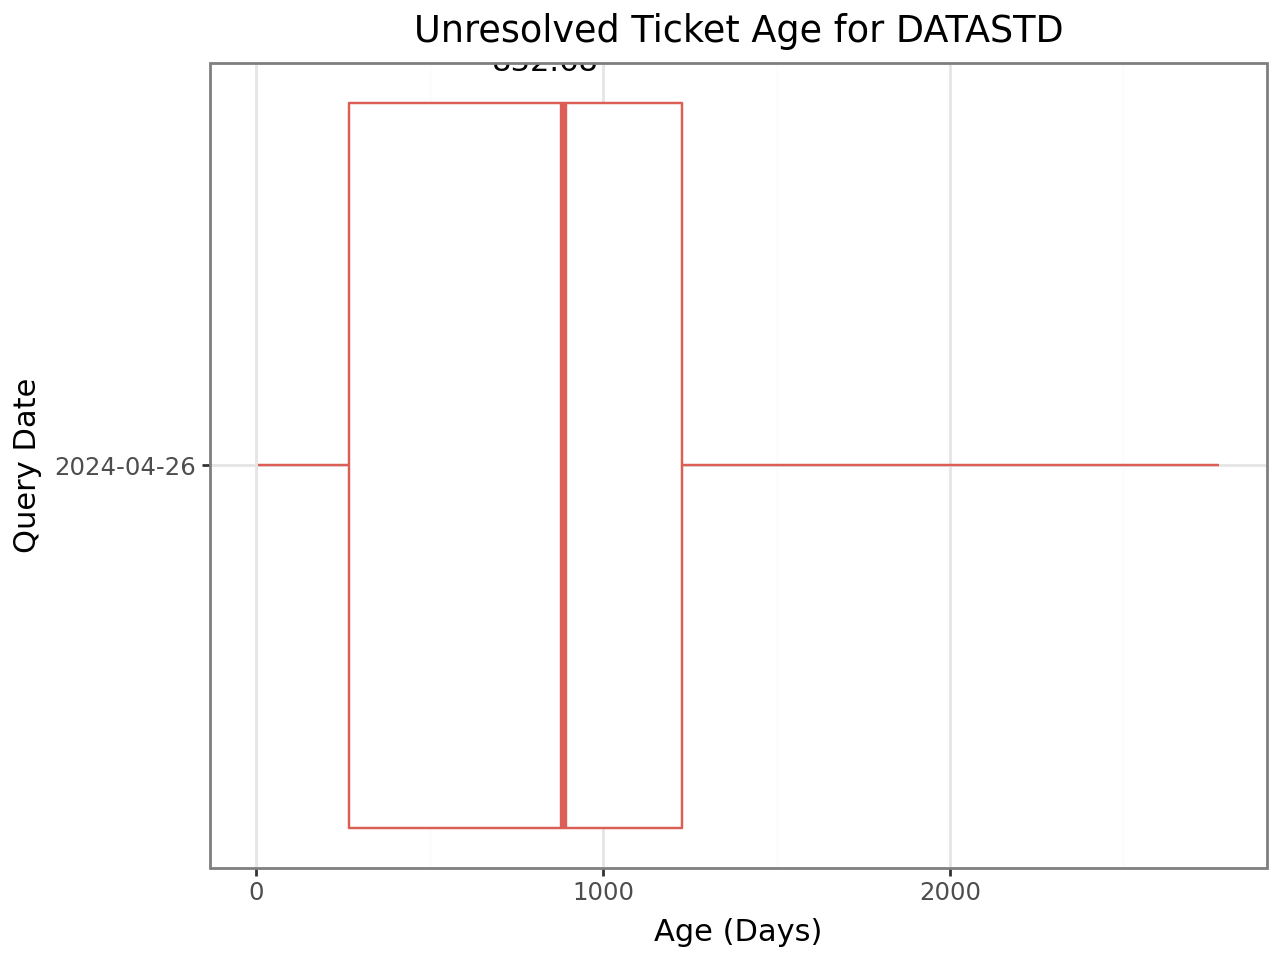

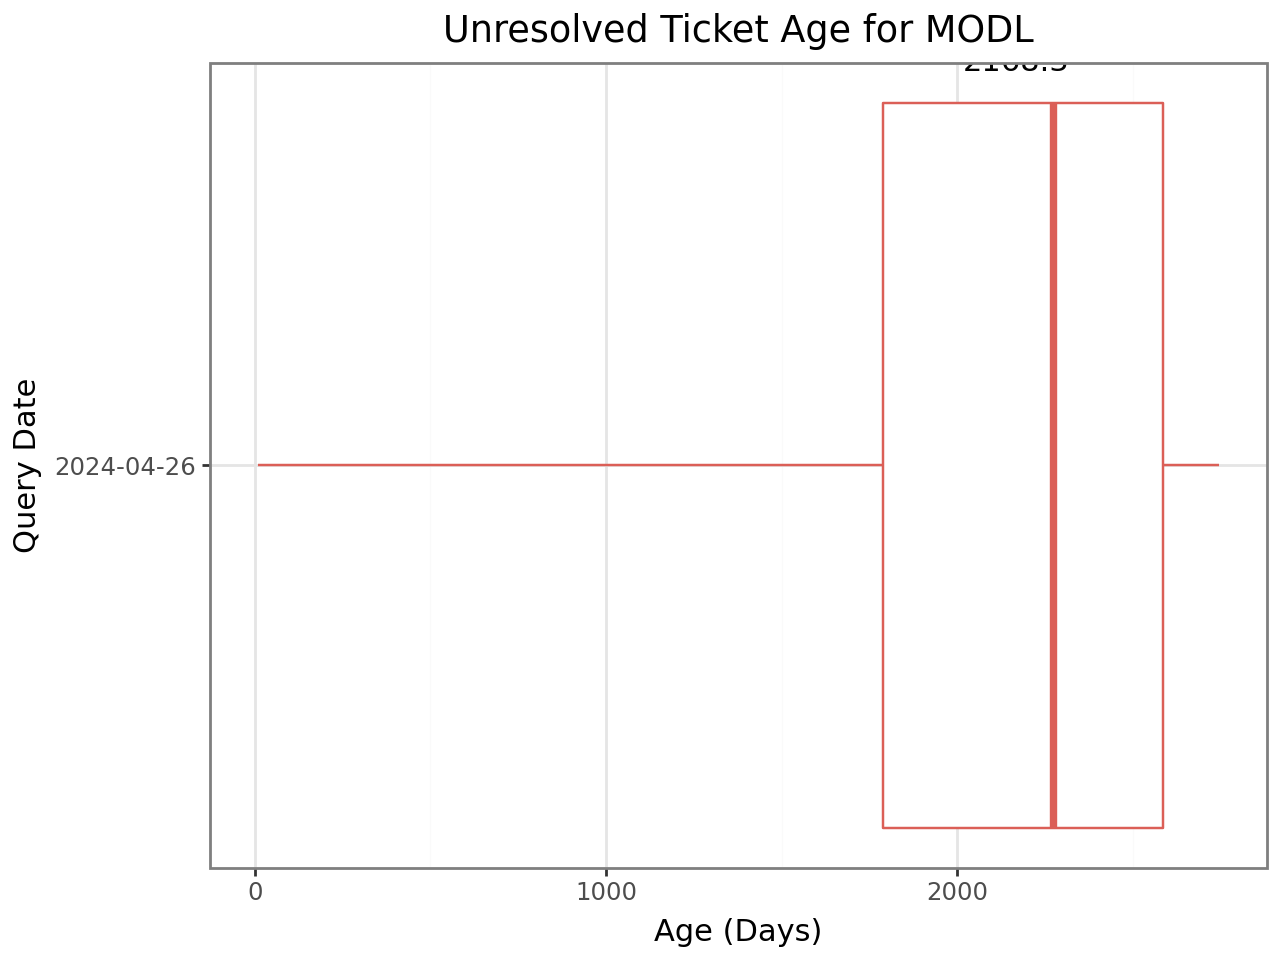

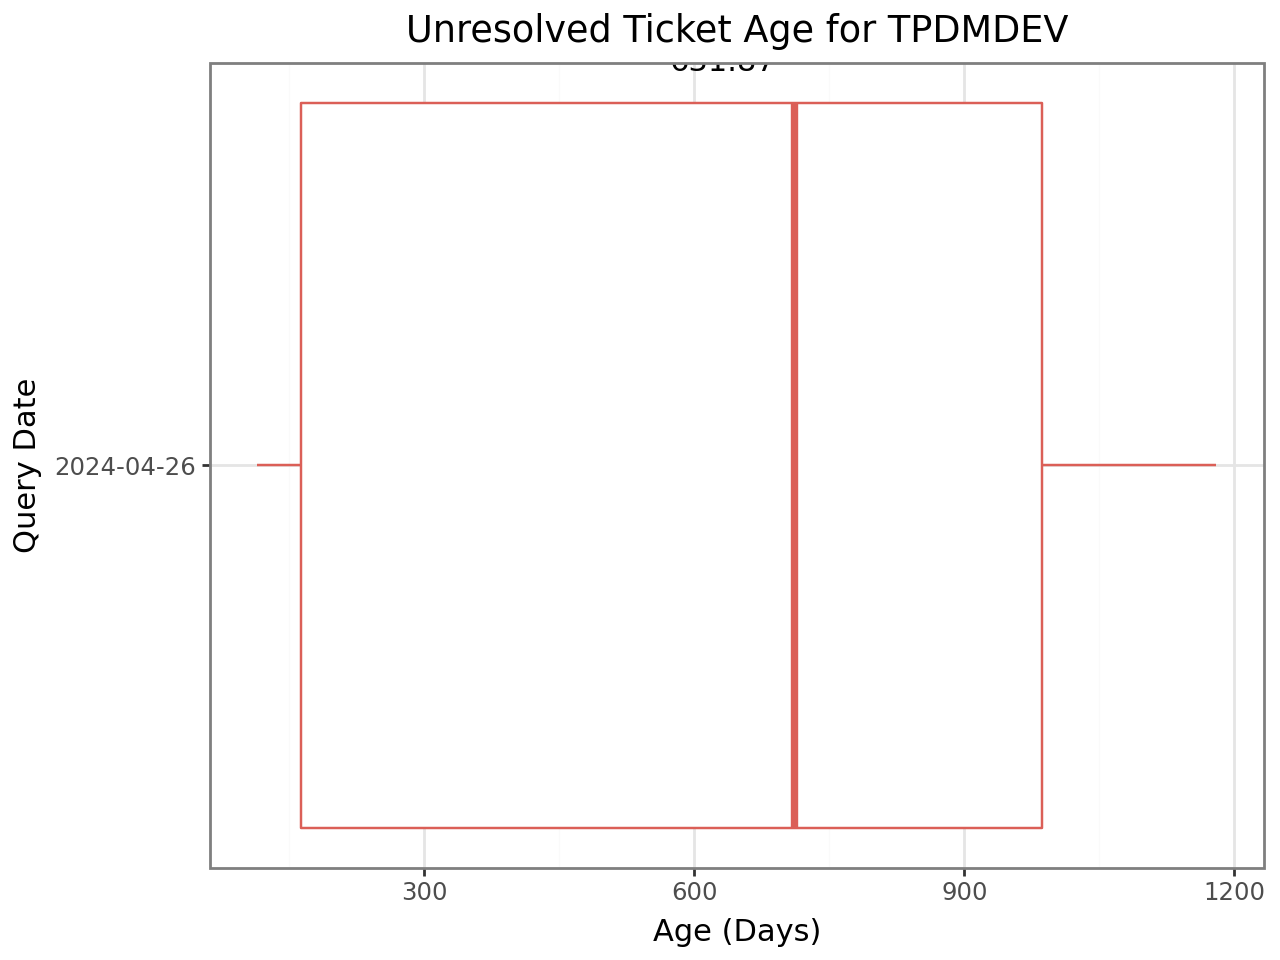

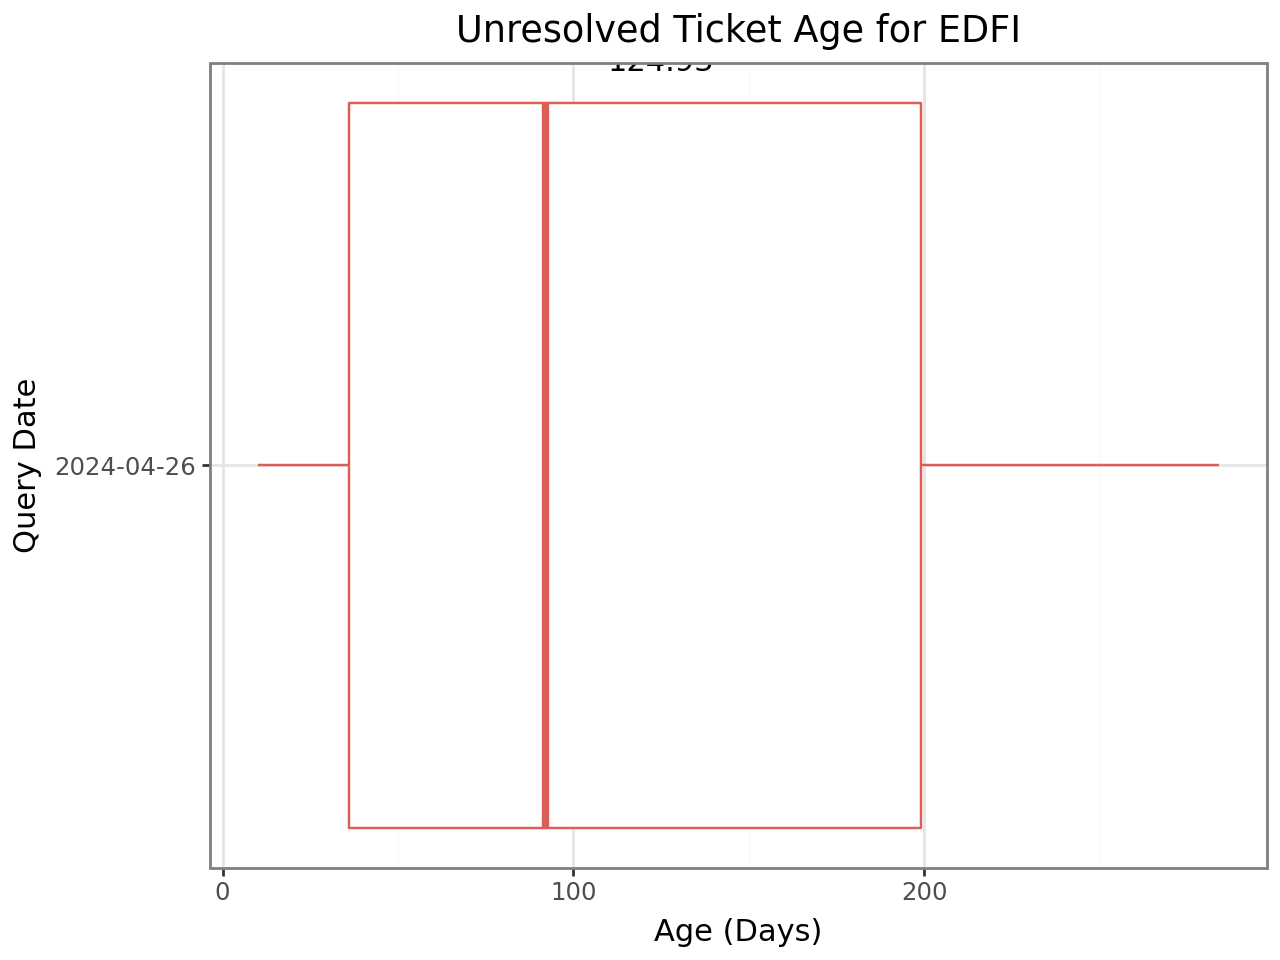

In [5]:
generate_ticket_age_plots("./data/ticket-age-filtered", projects)

## Backlog Health

Enter current team average velocity over the last five sprints below:

In [ ]:
import ipywidgets as widgets
from IPython.display import display, Markdown
import pandas as pd

def get_portfolio_health(team: str, velocity: int):
    total_points = df[df["project"].isin(portfolios[team])].points.sum()

    return { 
        "points": total_points,
        "velocity": velocity,
        "health": round(total_points/velocity)
    }

df_health = None
def build_health_report(data_standard, edfi_tools, ods_platform, team_b):
    global df_health
    ds_v = float(data_standard)
    tools_v = float(edfi_tools)
    ods_v = float(ods_platform)
    b_v = float(team_b)

    health = {}
    health["Data Standard"] = get_portfolio_health("Data Standard", ds_v)
    health["Ed-Fi Tools"] = get_portfolio_health("Ed-Fi Tools", tools_v)
    health["ODS Platform"] = get_portfolio_health("ODS Platform", ods_v)
    health["Team B"] = get_portfolio_health("Team B", b_v)
    
    df_health = pd.DataFrame(health).transpose()

# Default to 1.0 to avoid temporary divide by zero
_ = widgets.interact_manual(build_health_report, data_standard="1.0", edfi_tools="1.0", ods_platform="1.0", team_b="1.0")

In [ ]:
display(df_health)

path = "./data/backlog-health"
Path(path).mkdir(parents=True, exist_ok=True)

file_name = f"{path}/{today}.csv"
conf.info(f"Writing health data out to file: {file_name}")
df_health.to_csv(file_name)

## Todo

1. Account for fixed version.
   * Should we only care about age for things that are not assigned to a version? That gets to the real concern.
   * If so, that would be easy to game, with a fake fixed version (like "backlog" in MetaEd)
   * Should the health only look at items that are in fixed versions? The _next_ version perhaps?
2. Refactor to have less code visible in the notebook.